## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_stock_data, load_usa_cpi
from returns import prepare_ann_returns, prepare_mean_ann_returns
from returns import reinvestment_growth, dividend_yield

## Config

In [4]:
# Create directory for plots if it does not exist already.
path_plots = 'plots/long-term_stock_forecasting/'
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

## Load Data

In [5]:
# Tickers for the stocks we consider.
ticker_PG = 'PG'
ticker_WMT = 'WMT'

# Tickers for the stock-indices we consider.
ticker_SP500 = 'S&P 500'
ticker_SP400 = 'S&P 400'
ticker_SP600 = 'S&P 600'

# Tickers for stock-index ETF's.
ticker_QQQ = 'QQQ'
ticker_VGK = "VGK"
ticker_EWO = "EWO"
ticker_EEM = "EEM"

In [6]:
# Long titles used in some plots.
title_PG = 'PG (Procter & Gamble)'
title_WMT = 'WMT (Walmart)'

# Long titles for stock-indices.
title_SP500 = 'S&P 500 (US Large-Cap)'
title_SP400 = 'S&P 400 (US Mid-Cap)'
title_SP600 = 'S&P 600 (US Small-Cap)'

# Long titles for ETF's.
title_QQQ = 'QQQ (NASDAQ 100 ETF)'
title_VGK = 'VGK (Europe Developed ETF)'
title_EWO = 'EWO (Austria ETF)'
title_EEM = 'EEM (Emerging Markets ETF)'

In [7]:
# Load data for the stocks.
df_PG = load_stock_data(ticker=ticker_PG, dividend_TTM=True)
df_WMT = load_stock_data(ticker=ticker_WMT, dividend_TTM=True)

# Load data for the stock-indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600, book_value=False)

# Load data for ETF's which is treated like stock-data.
df_QQQ = load_stock_data(ticker=ticker_QQQ, earnings=False, book_value=False, dividend_TTM=True)
df_VGK = load_stock_data(ticker=ticker_VGK, earnings=False, book_value=False, dividend_TTM=True)
df_EWO = load_stock_data(ticker=ticker_EWO, earnings=False, book_value=False, dividend_TTM=True)
df_EEM = load_stock_data(ticker=ticker_EEM, earnings=False, book_value=False, dividend_TTM=True)

# Load data for Consumer Price Index (CPI).
df_CPI = load_usa_cpi()

## Helper Functions

In [8]:
def pct_formatter(num_decimals=0):
    """Percentage-formatter used in plotting."""
    return FuncFormatter(lambda x, _: '{:.{}%}'.format(x, num_decimals))

In [9]:
def normalize(x):
    """Normalize the array of floats `x` to be between 0 and 1."""
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min)

## Forecasting Model

In [10]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term stock returns.
    """

    def __init__(self, dividend_yield, sales_growth,
                 psales, years):
        """
        Create a new model and fit it with the given data.
        
        :param dividend_yield: Array with dividend yields.
        :param sales_growth: Array with one-year sales growth.
        :param psales: Array with P/Sales ratios.
        :param years: Number of years for annualized returns.
        """
        
        # Copy args to self.
        # Note the +1 for dividend yield and sales-growth
        # so we don't have to do it several times below.
        self.dividend_yield = np.array(dividend_yield) + 1
        self.sales_growth = np.array(sales_growth) + 1
        self.psales = psales
        self.years = years
        
        # Calculate the `a` parameter for the mean ann.return.
        self.a = self.mean_parameter()

        # Calculate the `b` parameter for the std.dev. ann.return.
        self.b = self.std_parameter()

    def forecast(self, psales_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future stock returns.
        
        :param psales_t: Array with different P/Sales ratios at buy-time.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the psales_t values.
        """

        # Annualized psales_t which is used in both formulas.
        psales_t_ann = psales_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of P/Sales ratios at the
        # time of buying the stock.
        mean = self.a / psales_t_ann - 1.0
        std = self.b / psales_t_ann

        return mean, std

    def mean_parameter(self):
        """
        Estimate the parameter `a` used in the formula for the
        mean annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        :return: The parameter `a` for the mean return formula.
        """

        # We assume dividend_yield and sales_growth is already +1.
        a = np.mean(self.dividend_yield) \
          * np.mean(self.sales_growth) \
          * np.mean(self.psales ** (1/self.years))

        return a

    def std_parameter(self, num_samples=10000):
        """
        Estimate the parameter `b` used in the formula for the
        std.dev. annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        This is estimated using Monte Carlo simulation / resampling
        of the given data, which is assumed to be independent of
        each other and over time.

        :param num_samples: Number of Monte Carlo samples.
        :return: The parameter `b` for the std.dev. return formula.
        """
        
        # We could also calculate the parameter `b` using the data
        # and formula more directly, but this requires that all the
        # data-arrays have the same length, and this also assumes
        # that the data is *dependent* over time in the given order.
        # For the historical stock-data, the results seem to be quite
        # similar to the MC simulations.
        # return np.std( self.dividend_yield * self.sales_growth * self.psales ** (1/self.years) )
        
        # We will now do a Monte Carlo simulation / resampling
        # from the supplied arrays of data. For each year
        # we take e.g. 10k random samples and then we
        # calculate the annualized growth-rates. This gives
        # us different values for dividend yields and sales-growth
        # for each year, instead of just taking one random
        # number and using that for all the years.

        # Shape of arrays to sample.
        shape = (num_samples, self.years)
        num_samples_total = np.prod(shape)

        # Sample the dividend yield. We assume it is already +1.
        dividend_yield_sample = np.random.choice(self.dividend_yield, size=shape)
        # Compound the growth through the years.
        dividend_yield_sample = np.prod(dividend_yield_sample, axis=1)

        # Sample the sales-growth. We assume it is already +1.
        sales_growth_sample = np.random.choice(self.sales_growth, size=shape)
        # Compound the growth through the years.
        sales_growth_sample = np.prod(sales_growth_sample, axis=1)

        # Sample the P/Sales ratio at the time of selling.
        psales_sample = np.random.choice(self.psales, size=num_samples)

        # Combine the three samples.
        combined_sample = dividend_yield_sample * sales_growth_sample * psales_sample

        # Calculate the `b` parameter.
        b = np.std(combined_sample ** (1/self.years))

        return b
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MAE(self, psales_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def R_squared(self, psales_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of one means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

## Plot the Return Curves

In [11]:
def plot_return_curves(years, a=1.0, filename=None, figsize=(10, 10)):
    """
    Plot the "return curves" for mean annualized return with
    different choices of years:

    ann_ret = a / (P/Sales ^ (1/year)) - 1
    
    :param years: Array of different years to plot.
    :param a: The `a` parameter in the formula above.
    :param filename: Full path to save figure to disk.
    :param figsize: Tuple with the figure-size.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(211)

    # Array of values for the x-axis.
    psales = np.linspace(start=0.5, stop=2, num=100)

    # For each year in the given array.
    for year in years:
        # Calculate "return curve" values for the y-axis.
        ann_ret = a / (psales ** (1/year)) - 1.0

        # Set the label for this curve and plot it.
        label = "Year = {0}".format(year)
        ax.plot(psales, ann_ret, label=label)

    # Show the labels for all the curves.
    ax.legend()
    
    # Set the labels for the axes.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Convert y-ticks to percentages.
    ax.yaxis.set_major_formatter(pct_formatter())
    
    # Show grid and mark the gain/loss lines.
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(1, color='black')
    
    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

    return ax

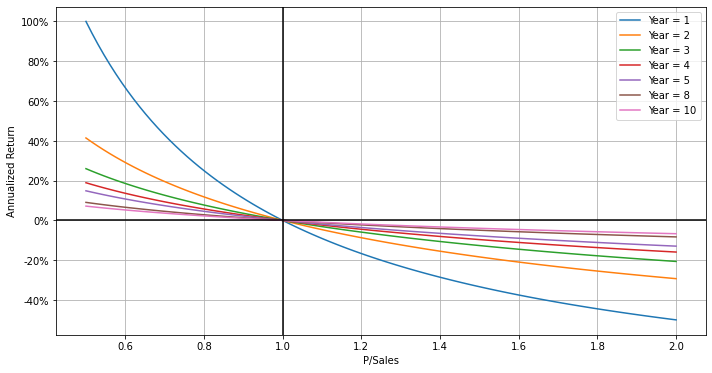

In [12]:
# Make the plot with Return Curves.
filename = os.path.join(path_plots, 'Return Curves.svg')
plot_return_curves(years=[1, 2, 3, 4, 5, 8, 10], filename=filename);

## Plotting Functions

In [13]:
def plot_with_mean_line(df, column, ax,
                        percentage=False, y_decimals=2):
    """
    Helper-function for plotting a single data-column and its mean.
    This function is used by the main plotting functions.

    :param df: Pandas DataFrame containing the given column.
    :param column: String with column-name to plot on y-axis.
    :param ax: Matplotlib Axis object.
    :param percentage: Show y-axis as percentage.
    :param y_decimals:
        Number of decimals to show if percentage is True.
    :return: None
    """

    # Make the basic plot.
    sns.lineplot(x=DATE, y=column, data=df.reset_index(),
                 ax=ax, label=column);

    # Mean of the data-column.
    mean = df[column].mean()

    # Create label for the mean.
    if percentage:
        # Convert y-ticks to percentages.
        ax.yaxis.set_major_formatter(pct_formatter(y_decimals))

        label_mean = 'Mean = {:.1%}'.format(mean)
    else:
        label_mean = 'Mean = {:.1f}'.format(mean)

    # Plot the mean of the given data-column.
    ax.axhline(mean, c='k', ls=':', label=label_mean)

    # Show the legend.
    ax.legend()

In [14]:
def plot_basic_data(title, df, log_shareprice=True,
                    filename=None, figsize=(10, 12.5)):
    """
    Create a plot with the basic financial data for a stock or index.
    
    :param title: Overall title for the plot.
    :param df: Pandas DataFrame with stock-data.
    :param log_shareprice: Use log-scale on y-axis for share-prices.
    :param filename: Full path to save figure to disk.
    :param figsize: Tuple with the figure-size.
    :return: Matplotlib Axis object.
    """
    
    # Select only the data we need.
    columns = [SALES_PER_SHARE, SHARE_PRICE, PSALES,
               SALES_GROWTH, DIVIDEND_YIELD]
    df2 = df[columns]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()
    
    # Change the index into a normal column.
    df3 = df2.reset_index()

    # Create a new plot with sub-plot rows.
    plt.rc('figure', figsize=figsize)
    fig, axs = plt.subplots(nrows=4)

    # Set the main plot-title.
    axs[0].set_title(title)

    # Use log-scale on the y-axis for share-prices?
    if log_shareprice:
        axs[0].set_yscale('log')

    # Plot the Share-Price and Sales Per Share.
    sns.lineplot(data=df2[[SHARE_PRICE, SALES_PER_SHARE]], ax=axs[0])

    # Plot the P/Sales.
    plot_with_mean_line(df=df3, column=PSALES, ax=axs[1])
    
    # Plot the Sales Growth.
    plot_with_mean_line(df=df3, column=SALES_GROWTH, ax=axs[2],
                        percentage=True, y_decimals=0)

    # Plot the Dividend Yield.
    plot_with_mean_line(df=df3, column=DIVIDEND_YIELD, ax=axs[3],
                        percentage=True, y_decimals=1)

    # Adjust all the sub-plots.
    for ax in axs:
        # Don't show the x-axis label.
        ax.set_xlabel(None)
        
        # Show grid.
        ax.grid(which='both')

    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

    return fig

In [15]:
def plot_ann_returns(ticker, df, years, years_range=0,
                     dividend_yield=None, sales_growth=None,
                     psales=None, psales_min=None, psales_max=None,
                     ax=None):
    """
    Create a plot with the actual historical returns showing
    the P/Sales ratios vs. future Annualized Returns.
    Overlay this plot with the estimated mean and std.dev.
    from the mathematical forecasting model.
    
    The optional params are taken from the DataFrame `df`
    if not supplied. This allows you to override some or
    all of the data used in the forecasting model e.g.
    to change assumptions about future sales-growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param years_range:
        If > 0 then plot the mean ann. returns between
        years - years_range and years + years_range.
    :param dividend_yield: (Optional) Array with dividend yields.
    :param sales_growth: (Optional) Array with one-year sales growth.
    :param psales: (Optional) Array with P/Sales ratios.
    :param psales_min: (Optional) Min P/Sales for plotting curves.
    :param psales_max: (Optional) Max P/Sales for plotting curves.
    :param ax: (Optional) Matplotlib Axis object for the plot.
    :return: None
    """
    
    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()
    
    # Create a new plot if no plotting-axis is supplied.
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(211)

    # Part of the title for the data's date-range.
    start_date, end_date = df2.index[[0, -1]]
    title_dates = "({0}-{1})".format(start_date.year, end_date.year)

    # Get the actual ann. returns from the historic data.
    if years_range > 0:
        # Use the mean. ann. returns between [min_years, max_years].
        min_years = years - years_range
        if min_years < 1:
            min_years = 1
        max_years = years + years_range

        # Get the mean ann.returns from the historic data.
        x, y = prepare_mean_ann_returns(df=df2,
                                        min_years=min_years,
                                        max_years=max_years,
                                        key=PSALES)

        # First part of the plot-title.
        title1 = "[{0}] {1}-{2} Year Mean Ann. Return {3}".format(ticker, min_years, max_years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns (Mean)"
    else:
        # Get the ann.returns from the historic data.
        x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)
    
        # First part of the plot-title.
        title1 = "[{0}] {1}-Year Ann. Return {2}".format(ticker, years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns"

    # Get Dividend Yield if none provided.
    if dividend_yield is None:
        dividend_yield = df2[DIVIDEND_YIELD]

    # Get Sales Growth if none provided.
    if sales_growth is None:
        sales_growth = df2[SALES_GROWTH]

    # Get P/Sales if none provided.
    if psales is None:
        psales = df2[PSALES]

    # Get min P/Sales for plotting if none provided.
    if psales_min is None:
        psales_min = np.min(psales)
    
    # Get max P/Sales for plotting if none provided.
    if psales_max is None:
        psales_max = np.max(psales)
        
    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=dividend_yield,
                          sales_growth=sales_growth,
                          psales=psales, years=years)

    # Evenly spaced P/Sales ratios between historic min and max.
    psales_t = np.linspace(start=psales_min, stop=psales_max, num=100)

    # Use the model to forecast the mean and std ann.returns.
    mean, std = model.forecast(psales_t=psales_t)

    # Plot the mean ann.return with the R^2 for how well
    # it fits the actual ann.return.
    R_squared = model.R_squared(psales_t=x, ann_rets=y)
    label = "Forecast Mean (R^2 = {0:.2f})".format(R_squared)
    ax.plot(psales_t, mean, color="black", label=label)
    
    # Plot one standard deviation.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(psales_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(psales_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)
    
    # Plot two standard deviations.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(psales_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(psales_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(psales_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Scatter-plot with the actual P/Sales vs. Ann.Returns.
    # Each dot is colored according to its date (array-position).
    # The dots are rasterized (turned into pixels) to save space
    # when saving to vectorized graphics-file.
    n = len(x)
    c = np.arange(n) / n
    ax.scatter(x, y, marker='o', c=c, cmap='plasma',
               label=label_returns, rasterized=True)

    # Plot mean of Ann.Returns. as horizontal dashed line.
    y_mean = np.mean(y)
    label = 'Actual Mean = {0:.1%}'.format(y_mean)
    ax.axhline(y=y_mean, color="black", linestyle=":", label=label)

    # Show the labels for what we have just plotted.
    ax.legend()

    # Create plot-title.
    # Second part of the title. Formula for mean ann. return.
    msg = "E[Ann Return] = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[Ann Return] = {0:.3f} / (P/Sales ^ (1/{1}))"
    title3 = msg.format(model.b, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    ax.yaxis.set_major_formatter(pct_formatter())

    # Set axes labels.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Show grid.
    ax.grid()
    
    return ax

In [16]:
def plot_ann_returns_multi(years, years_range=0, filename=None,
                           figsize=None, *args, **kwargs):
    """
    Create plot with multiple sub-plots from `plot_ann_returns`
    for different years and years_range.
    
    :param years: List of years.
    :param years_range: Either integer or list of integers.
    :param filename: Full path to save figure to disk.
    :param figsize: Tuple with the figure-size.
    :return: Matplotlib Figure
    """
    
    # Number of sub-plots to create, one for each year.
    n = len(years)

    # Ensure `years_range` is a list or numpy array.
    if not isinstance(years_range, (list, np.ndarray)):
        years_range = np.repeat(years_range, repeats=n)

    # Figure size.
    if figsize is None:
        figsize = (10, 12.5 * n / 3)
        
    # Create new plot with sub-plots.
    fig, axs = plt.subplots(nrows=n, figsize=figsize)
    
    # Create each of the sub-plots.
    for ax, y, y_range in zip(axs, years, years_range):
        plot_ann_returns(ax=ax, years=y, years_range=y_range,
                         *args, **kwargs)
    
    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

    return fig

In [17]:
def make_all_plots(title, ticker, df):
    """
    Create all the plots for a stock or stock-index.
    
    :param title: Long title for the stock.
    :param ticker: Ticker for the stock.
    :param df: Pandas DataFrame with data for the stock.
    :return: None
    """
    
    # Plot basic stock-data.
    filename = os.path.join(path_plots, ticker + ' Basic Data.svg')
    plot_basic_data(title=title, df=df, filename=filename);
    
    # Plot P/Sales vs. Ann.Returns for different years.
    filename = os.path.join(path_plots, ticker + ' Ann Returns.svg')
    plot_ann_returns_multi(filename=filename,
                           ticker=ticker, df=df,
                           years=[1, 5, 10]);

    # Plot P/Sales vs. Ann.Returns for different years and ranges.
    filename = os.path.join(path_plots, ticker + ' Ann Returns (Mean).svg')
    plot_ann_returns_multi(filename=filename,
                           ticker=ticker, df=df,
                           years=[3, 5, 8], years_range=[1, 1, 2]);

    # Show the plots.
    plt.show()

In [18]:
def plot_ann_returns_error(ticker, df, years, years_range=0,
                           ax=None, filename=None, figsize=(10, 12.5)):
    """
    Create 4 sub-plots. The first compares the forecasted mean
    return to the actual return. The second plot is for the
    P/Sales ratio, the third plot is for the Sales Per Share,
    and the fourth is for the Sales Growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param years_range:
        If > 0 then plot the mean ann. returns between
        years - years_range and years + years_range.
    :param filename: Filename for saving the plot.
    :param figsize: Figure size.
    :return: Matplotlib Figure object.
    """
    
    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_PER_SHARE,
              SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()
    
    # Create new plot with sub-plots.
    fig, axs = plt.subplots(nrows=4, figsize=figsize)

    # Part of the title for the data's date-range.
    start_date, end_date = df2.index[[0, -1]]
    title_dates = "({0}-{1})".format(start_date.year, end_date.year)

    # Get the actual ann. returns from the historic data.
    if years_range > 0:
        # Use the mean. ann. returns between [min_years, max_years].
        min_years = years - years_range
        if min_years < 1:
            min_years = 1
        max_years = years + years_range

        # Get the mean ann.returns from the historic data.
        x, y = prepare_mean_ann_returns(df=df2,
                                        min_years=min_years,
                                        max_years=max_years,
                                        key=PSALES)

        # First part of the plot-title.
        title1 = "[{0}] {1}-{2} Year Mean Ann. Return {3}".format(ticker, min_years, max_years, title_dates)
    else:
        # Get the ann.returns from the historic data.
        x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)
    
        # First part of the plot-title.
        title1 = "[{0}] {1}-Year Ann. Return {2}".format(ticker, years, title_dates)

    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=df2[DIVIDEND_YIELD],
                          sales_growth=df2[SALES_GROWTH],
                          psales=df2[PSALES], years=years)

    # Use forecasting model with historical P/Sales ratios
    # to get the forecasted mean and std.dev. ann. returns.
    mean, std = model.forecast(psales_t=x)
    
    # Plot the Actual vs. Forecasted mean return.
    data = \
    {
        'Actual Return': y,
        'Forecasted Mean Return': mean,
    }
    df3 = pd.DataFrame(data=data, index=df2.index)
    sns.lineplot(data=df3, ax=axs[0])
    # Hack to show the same Dates on the x-axis as plots below,
    # because sns.lineplot() removes the rows with NAN.
    sns.lineplot(x=df3.index, y=0, ax=axs[0], alpha=0)
    # Set label for y-axis.
    axs[0].set_ylabel('Annualized Return')
    # Convert y-ticks to percentages.
    axs[0].yaxis.set_major_formatter(pct_formatter())

    # Plot P/Sales.
    plot_with_mean_line(df=df2, column=PSALES, ax=axs[1])
    
    # Plot Sales Per Share.
    plot_with_mean_line(df=df2, column=SALES_PER_SHARE, ax=axs[2])

    # Plot Sales Growth.
    plot_with_mean_line(df=df2, column=SALES_GROWTH, ax=axs[3],
                        percentage=True, y_decimals=0)

    # Create plot-title.
    # Second part of the title. Formula for mean ann. return.
    msg = "Forecasted Mean Return = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2])
    axs[0].set_title(title)

    # Adjust all the sub-plots.
    for ax in axs:
        # Don't show the x-axis label.
        ax.set_xlabel(None)
        
        # Show grid.
        ax.grid(which='both')

    # Adjust padding.
    fig.tight_layout()

    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')
    
    return fig

## Print Statistics

In [19]:
def print_stats(df):
    """Print basic statistics for the financial data in `df`."""
    
    # Get the data-columns we are interested in and remove NA.
    df2 = df[[SHARE_PRICE, TOTAL_RETURN,
              PSALES, SALES_GROWTH, DIVIDEND_YIELD]].dropna()
    
    # Print basic statistics.
    display(df2.describe())
    
    # Print the first rows.
    display(df2.head())
    
    # Print the last rows.
    display(df2.tail())

## Synthetic Data

In [20]:
def synth_data(num_years=20,
               psales_start=1.0, psales_end=1.0,
               psales_cycle_years=3,
               psales_cycle_scale=0.5,
               psales_rand_scale=0.5,
               sales_growth_start=0.05, sales_growth_end=0.05,
               sales_growth_rand_scale=0.02):
    """
    Generate synthetic stock-data for the P/Sales ratio,
    annual growth in Sales Per Share, and Share-Price.
    The Dividend Yield is set to zero.
    
    The P/Sales ratio has 3 components:
    - A value that changes linearly from start to end.
    - A sinus value that changes cyclically.
    - A random value with unpredictable noise.

    The annual growth in Sales Per Share has 2 components:
    - A value that changes linearly from start to end.
    - A random value with unpredictable noise.
    
    The Share-Price is the product of P/Sales * Sales Per Share.
    
    The scale of the components can be set as parameters.
    
    :param num_years:
        Number of years for the daily synthetic data.
    :param psales_start:
        Start-value for the linear component of P/Sales.
    :param psales_end:
        End-value for the linear component of P/Sales.
    :param psales_cycle_years:
        Period in years for a full sinus-cycle of P/Sales.
    :param psales_cycle_scale:
        Scale of the cyclical component of P/Sales.
    :param psales_random_scale:
        Scale of the random component of P/Sales.
    :param sales_growth_start:
        Start-value for the linear component of Sales Growth.
    :param sales_growth_end:
        End-value for the linear component of Sales Growth.
    :param sales_growth_rand_scale:
        Scale of the random component of Sales Growth.
    :return:
        Pandas DataFrame with synthetic data.
    """
    # Dates for the synthetic data starting on '2000-01-01'
    # and ending on e.g. '2020-01-01' for a 20-year period.
    date_index = pd.date_range(start='2000',
                               end=str(2000+num_years), freq='d')
    
    # Total number of steps or data-points.
    num_steps = len(date_index)
    
    # Index as fractional years ranging from zero to e.g. 20.
    index = np.arange(start=0, stop=num_steps) * num_years / num_steps

    # Linear component of P/Sales.
    psales = np.linspace(start=psales_start,
                         stop=psales_end, num=num_steps)
    
    # Add cyclical / sinus component to P/Sales.
    psales += psales_cycle_scale * np.sin(2 * np.pi * index / psales_cycle_years)

    # Add random component to P/Sales.
    # This is a "random walk" that is normalized to be between
    # 0 and 1 so it is easier to scale and therefore control
    # its impact on the overall P/Sales data.
    rand = np.random.normal(loc=0.0, scale=1.0, size=num_steps)
    rand = np.cumsum(rand)
    rand = normalize(rand)
    psales += psales_rand_scale * rand
    
    # Linear component of the Sales Growth.
    # Note: This has only one data-point per year.
    sales_growth_yearly = np.linspace(start=sales_growth_start,
                                      stop=sales_growth_end,
                                      num=num_years)

    # Add random component to the Sales Growth.
    sales_growth_yearly += sales_growth_rand_scale * np.random.normal(size=num_years)

    # Convert the Sales Growth to Sales Per Share starting at 1.
    # Note: This has only one data-point per year.
    sales_per_share_yearly = np.append(1.0, np.cumprod(1 + sales_growth_yearly[:-1]))

    # Interpolate the yearly data-points into daily data-points.
    # Note: This results in slight distortion of the annual growth
    # in Sales Per Share, but has the advantage of creating a
    # "smooth" plot instead of "stair-cases" in the Sales Growth.
    # We also use such linear interpolation on the real-world data
    # for Sales Per Share.
    years = np.linspace(start=0.0, stop=num_years, num=num_years)
    sales_per_share = np.interp(x=index, xp=years, fp=sales_per_share_yearly)
    sales_growth = np.interp(x=index, xp=years, fp=sales_growth_yearly)

    # Calculate daily Share-Price from P/Sales and Sales Per Share.
    share_price = psales * sales_per_share

    # Create Pandas DataFrame.
    # Note: We set the Dividend Yield to zero so the
    # Total Return is equal to the Share-Price.
    data = \
    {
        DATE: date_index,
        PSALES: psales,
        SALES_PER_SHARE: sales_per_share,
        SALES_GROWTH: sales_growth,
        SHARE_PRICE: share_price,
        TOTAL_RETURN: share_price,
        DIVIDEND_YIELD: 0,
    }
    df = pd.DataFrame(data=data).set_index(DATE)

    return df

In [21]:
def make_all_plots_synth(title, ticker, df, cycle_years,
                         plot_sales_growth=True):
    """
    Create all the plots for synthetic stock-data.
    
    :param title: Long title for the stock.
    :param ticker: Ticker for the stock.
    :param df: Pandas DataFrame with data for the stock.
    :param cycle_years:
        Period in years for a full sinus-cycle of P/Sales.
    :return: None
    """
    
    # Plot basic stock-data.
    filename = os.path.join(path_plots, ticker + ' Basic Data.svg')
    plot_basic_data(title=title, df=df, filename=filename);
    
    # Plot P/Sales vs. Ann.Returns for different years.
    filename = os.path.join(path_plots, ticker + ' Ann Returns.svg')
    plot_ann_returns_multi(filename=filename,
                           ticker=ticker, df=df,
                           years=[1, cycle_years, 2*cycle_years]);

    # Plot P/Sales vs. Ann.Returns for different years and ranges.
    filename = os.path.join(path_plots, ticker + ' Ann Returns (Mean).svg')
    plot_ann_returns_multi(filename=filename,
                           ticker=ticker, df=df,
                           years=[2, cycle_years, 2*cycle_years],
                           years_range=[1, cycle_years/2, cycle_years/2]);

    # Show the plots.
    plt.show()

In [22]:
# Number of years for a full sinus-cycle of P/Sales.
cycle_years = 4

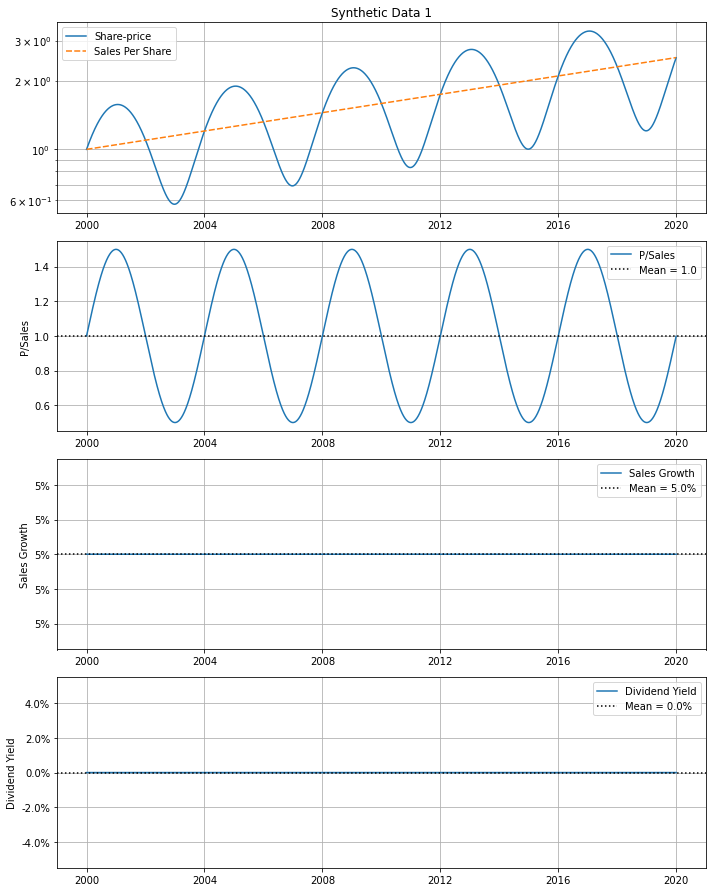

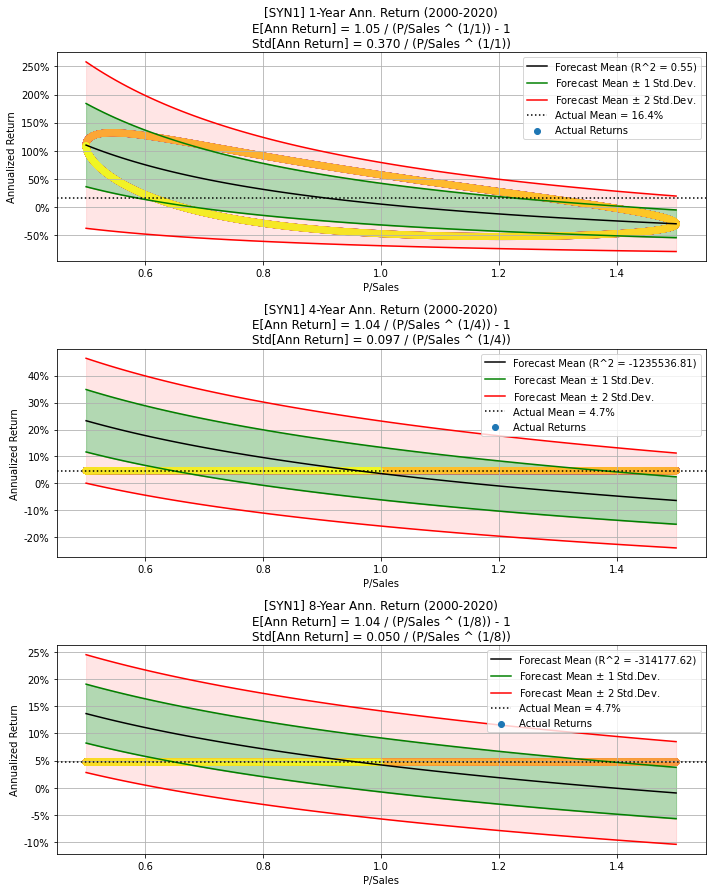

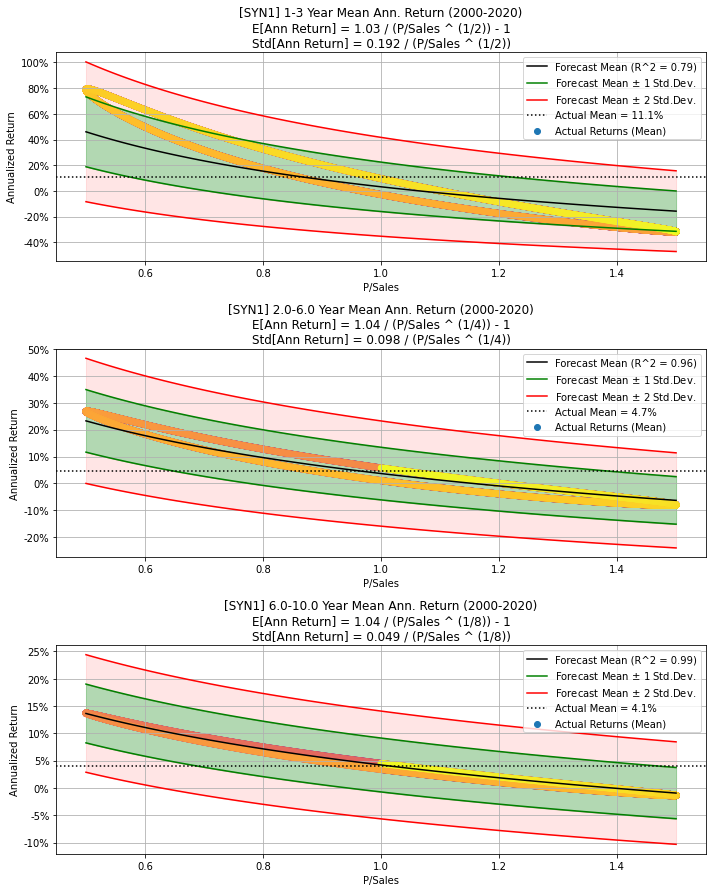

In [23]:
# Synthetic data with cyclical P/Sales and constant Sales Growth,
# and no random noise.

df = synth_data(num_years=20, psales_cycle_years=cycle_years,
                psales_cycle_scale=0.5, psales_rand_scale=0.0,
                sales_growth_rand_scale=0.0)

make_all_plots_synth(title='Synthetic Data 1', ticker='SYN1',
                     df=df, cycle_years=cycle_years,
                     plot_sales_growth=False)

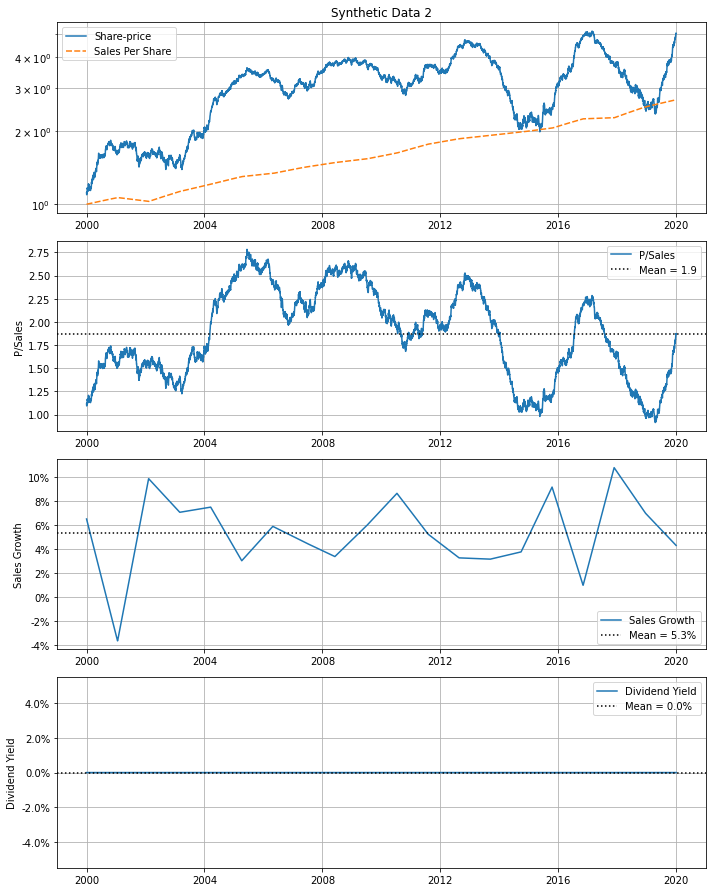

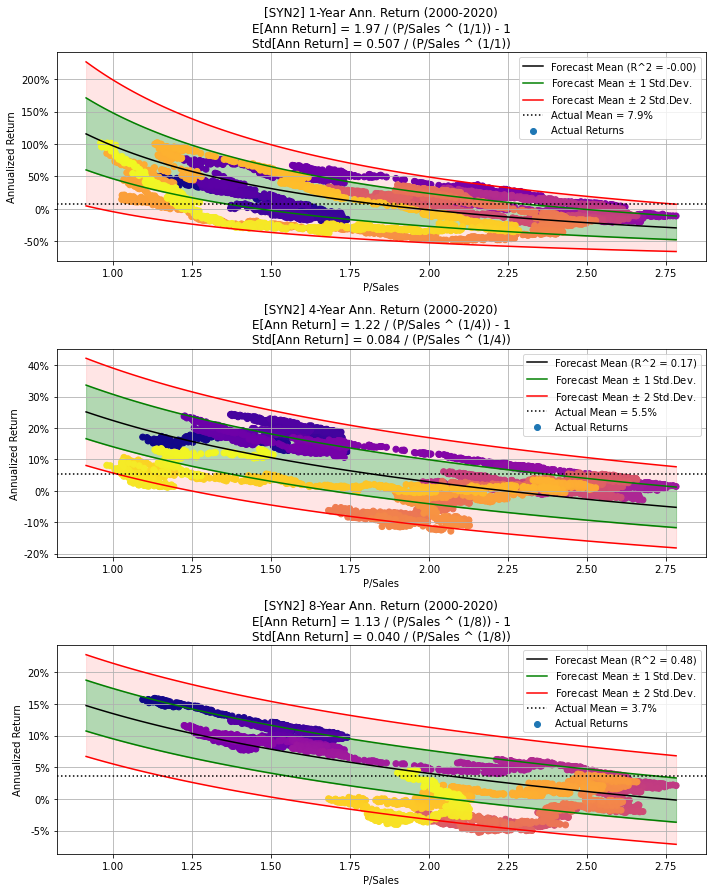

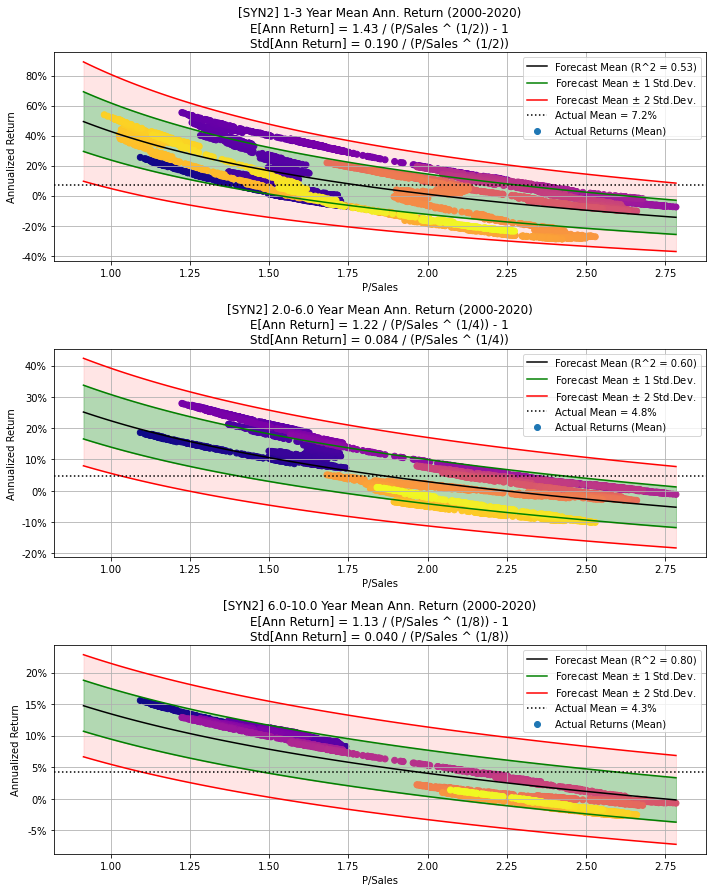

In [24]:
# Synthetic data with partially random P/Sales and Sales Growth.

# Random seed to make these experiments repeatable.
np.random.seed(987654321)

df = synth_data(num_years=20, psales_cycle_years=cycle_years,
                psales_cycle_scale=0.5, psales_rand_scale=1.8,
                sales_growth_rand_scale=0.03)

make_all_plots_synth(title='Synthetic Data 2', ticker='SYN2',
                     df=df, cycle_years=cycle_years)

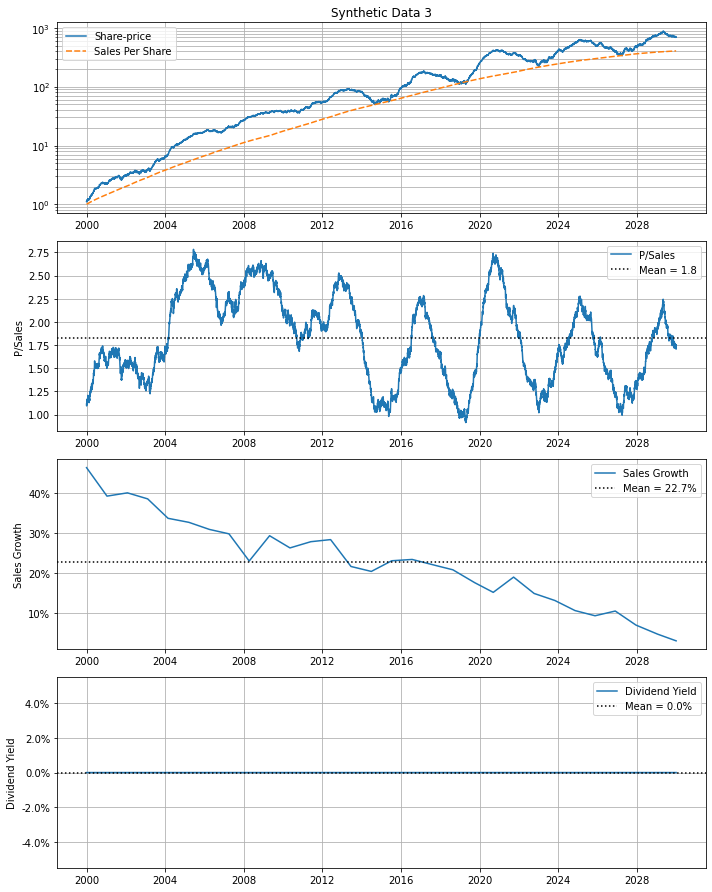

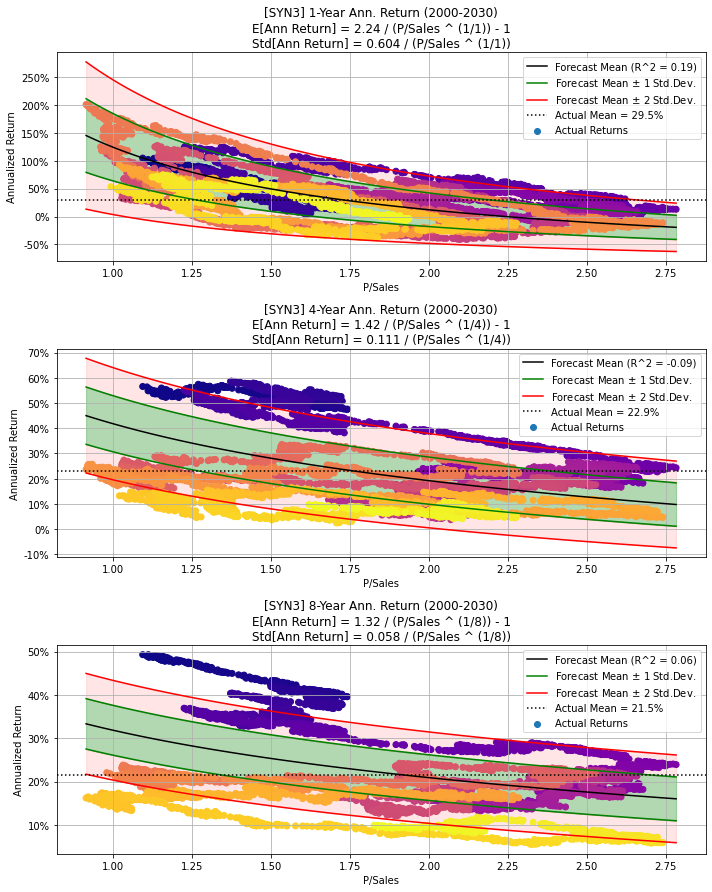

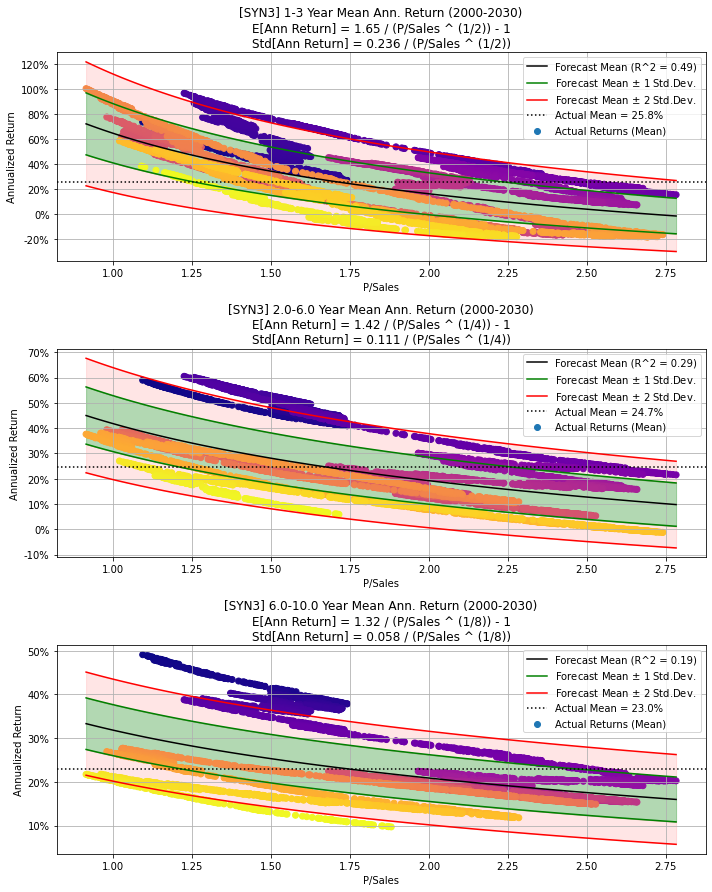

In [25]:
# Synthetic data with partially random P/Sales and Sales Growth,
# and Sales Growth decreases linearly from 40% to 5%.
# Note the data-period is increased to 30 years.

# Random seed to make these experiments repeatable.
np.random.seed(987654321)

df = synth_data(num_years=30, psales_cycle_years=cycle_years,
                psales_cycle_scale=0.5, psales_rand_scale=1.8,
                sales_growth_start=0.4, sales_growth_end=0.05,
                sales_growth_rand_scale=0.03)

make_all_plots_synth(title='Synthetic Data 3', ticker='SYN3',
                     df=df, cycle_years=cycle_years)

## S&P 500 (US Large-Cap)

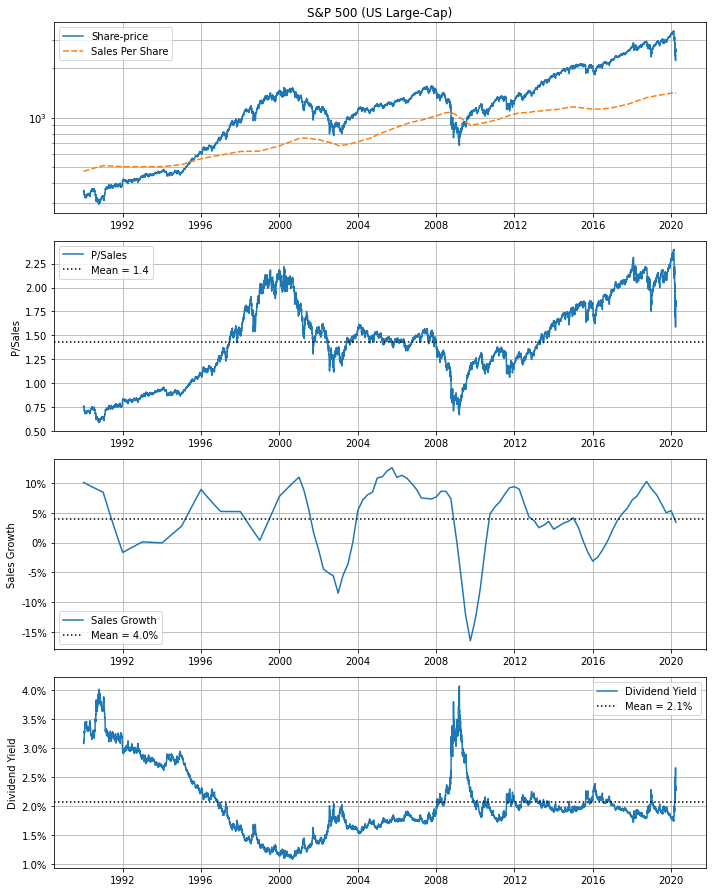

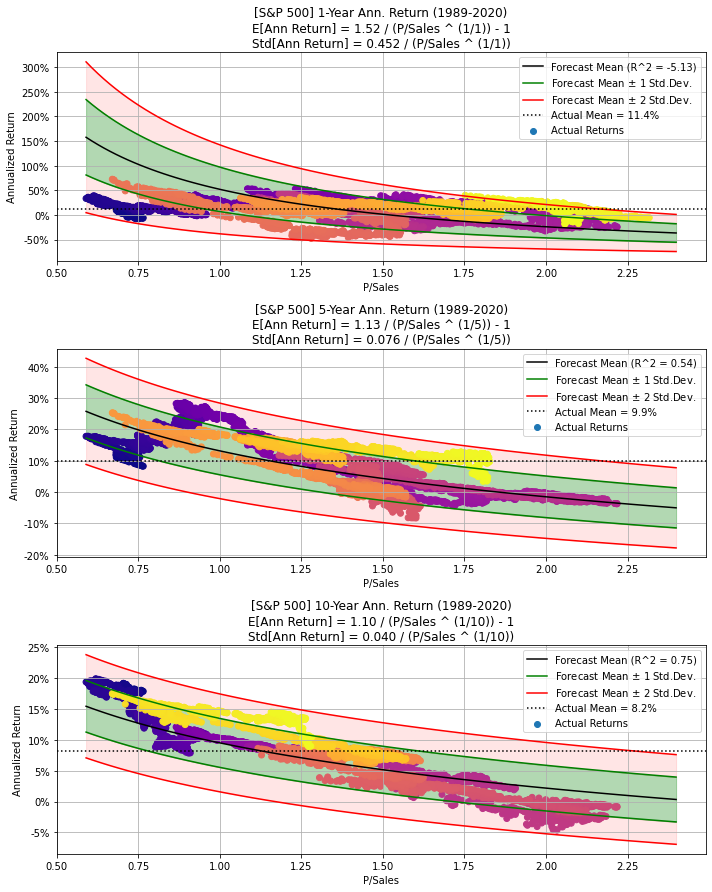

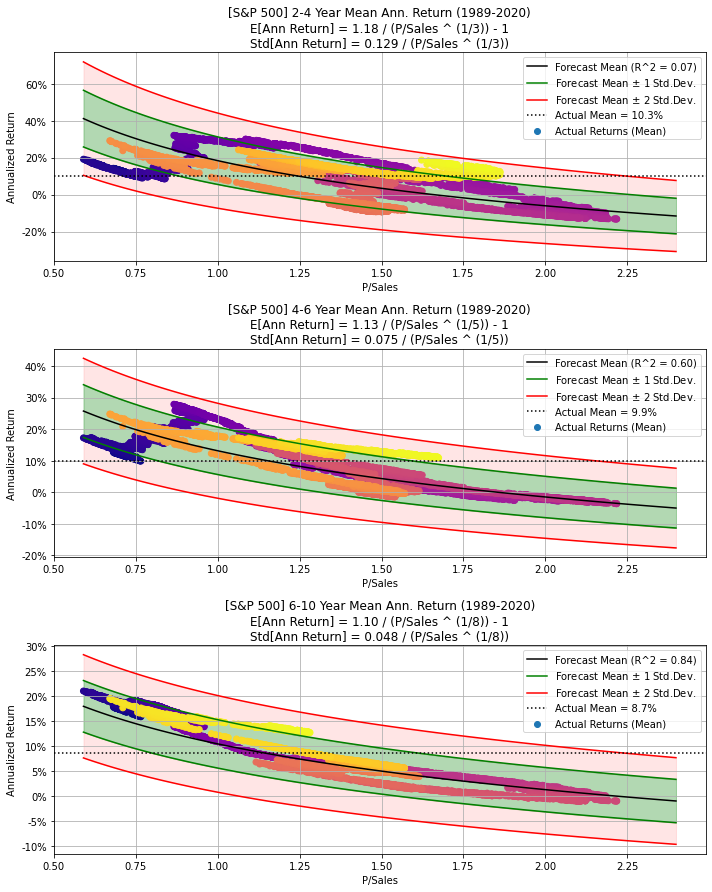

In [26]:
make_all_plots(title=title_SP500, ticker=ticker_SP500, df=df_SP500)

In [27]:
print_stats(df=df_SP500)

Share-price  Total Return       P/Sales  Sales Growth  Dividend Yield
count  11049.000000  11049.000000  11049.000000  11049.000000    11049.000000
mean    1282.316533    587.609947      1.433628      0.039587        0.020685
std      689.304034    407.440466      0.426439      0.052883        0.005807
min      295.459991     90.737998      0.590104     -0.164586        0.010819
25%      825.159973    326.153869      1.142705      0.007714        0.017342
50%     1197.232483    498.624264      1.447133      0.050109        0.019473
75%     1504.429972    677.630110      1.759618      0.080451        0.022373
max     3386.149902   1901.327220      2.398862      0.125595        0.040702

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
1989-12-31   356.544998    106.625419  0.758978      0.100834        0.030992
1990-01-01   358.117500    107.095678  0.762149      0.100785        0.030864
1990-01-02   359.690002    107.565938  0.765318      0.100736        0.030738
1990-01-03   358.760010    107.287822  0.763162      0.100687        0.030826
1990-01-04   355.670013    106.363753  0.756414      0.100639        0.031102

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2020-03-27  2541.469971   1427.038429  1.803720      0.035082        0.023420
2020-03-28  2569.863281   1442.981307  1.823961      0.034872        0.023167
2020-03-29  2598.256592   1458.924184  1.844203      0.034677        0.022919
2020-03-30  2626.649902   1474.867062  1.864447      0.034482        0.022677
2020-03-31  2584.590088   1459.852624  1.834682      0.034287        0.023052

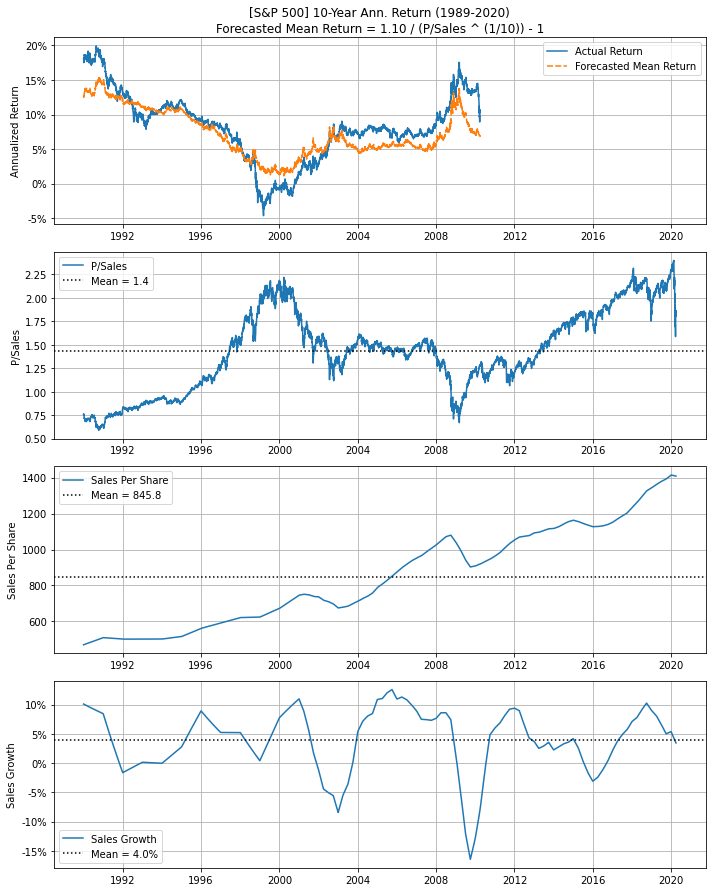

In [28]:
plot_ann_returns_error(ticker=ticker_SP500, df=df_SP500, years=10);

## S&P 400 (US Mid-Cap)

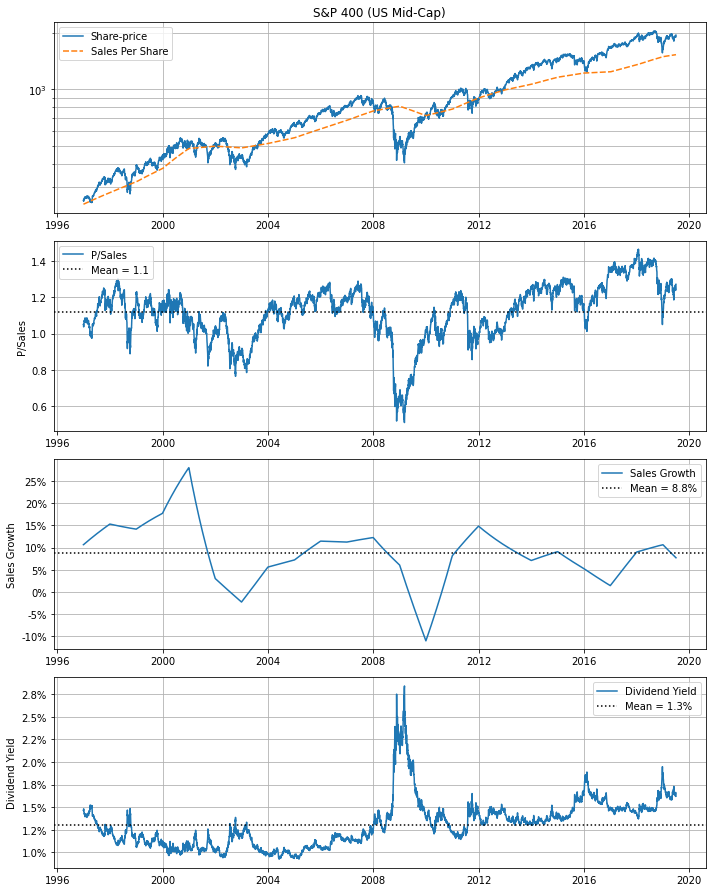

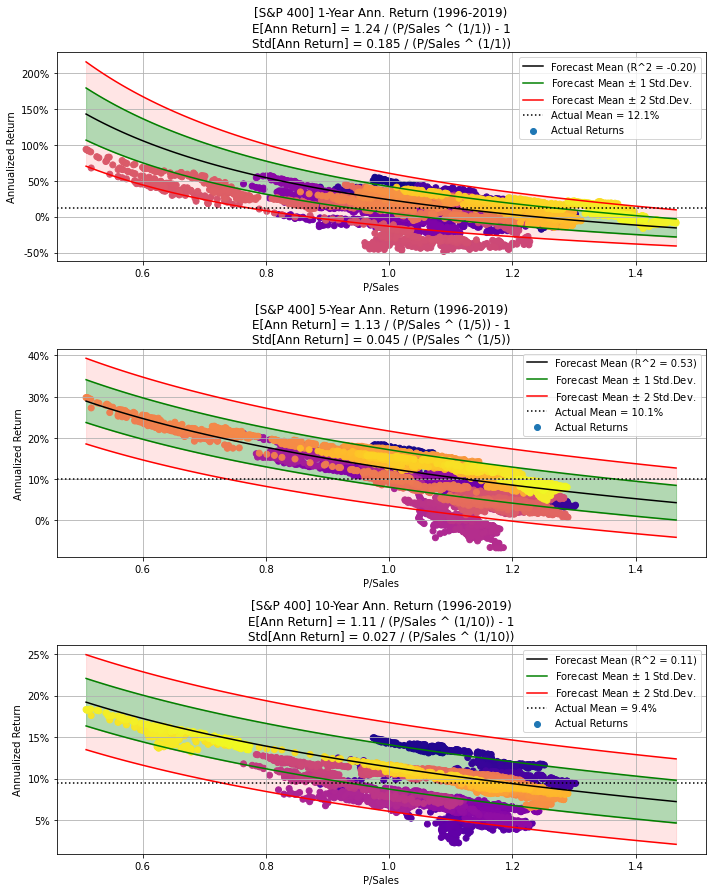

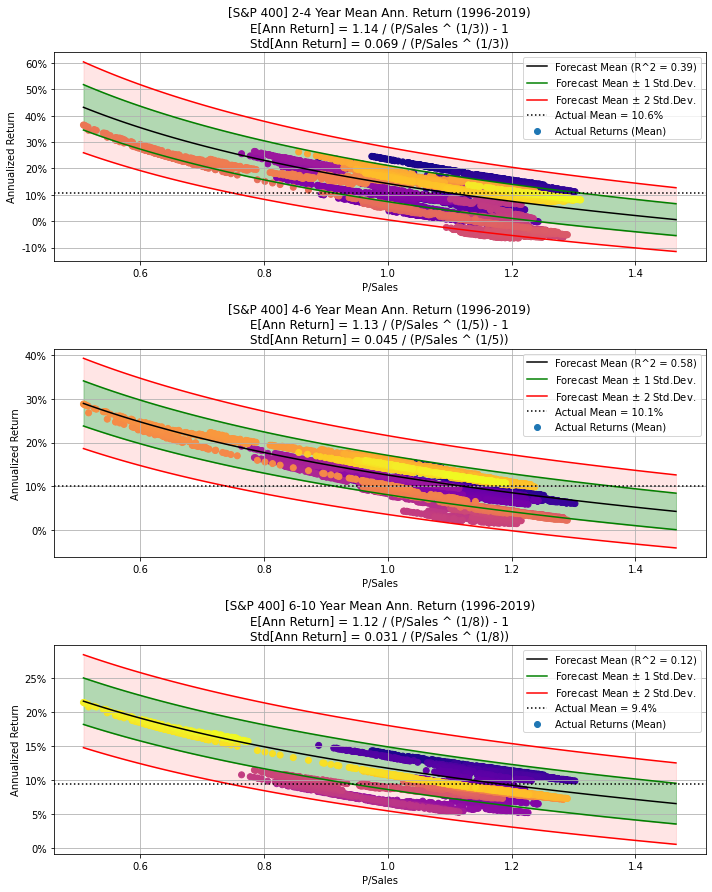

In [29]:
make_all_plots(title=title_SP400, ticker=ticker_SP400, df=df_SP400)

In [30]:
print_stats(df=df_SP400)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  8218.000000   8218.000000  8218.000000   8218.000000     8218.000000
mean    891.209960     49.036278     1.121455      0.088142        0.013094
std     482.769501     30.780731     0.153752      0.064775        0.002650
min     248.039993     11.323931     0.508140     -0.109900        0.009265
25%     501.399994     24.234128     1.033765      0.056222        0.011052
50%     768.265015     39.768585     1.142628      0.090922        0.012926
75%    1281.204987     73.068129     1.221969      0.120520        0.014548
max    2050.229980    124.720562     1.465477      0.280169        0.028419

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
1996-12-30   255.360001     11.599574  1.051401      0.106748        0.014646
1996-12-31   255.580002     11.623649  1.052029      0.106717        0.014633
1997-01-01   253.845001     11.544742  1.044449      0.106857        0.014730
1997-01-02   252.110001     11.465835  1.036876      0.106998        0.014827
1997-01-03   255.669998     11.627742  1.051077      0.107138        0.014617

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-06-26  1898.619995    117.151947  1.239252      0.077850        0.016644
2019-06-27  1922.300049    118.613095  1.254540      0.077696        0.016444
2019-06-28  1945.510010    120.045236  1.269517      0.077541        0.016253
2019-06-29  1947.800008    120.186538  1.270841      0.077386        0.016239
2019-06-30  1950.090007    120.530715  1.272164      0.077231        0.016225

In [31]:
# Get the data used by the forecasting model and remove missing rows.
df = df_SP400[[PSALES, SALES_GROWTH, DIVIDEND_YIELD]].dropna()

In [32]:
# Statistics for the entire data-period.
df.describe()

P/Sales  Sales Growth  Dividend Yield
count  8218.000000   8218.000000     8218.000000
mean      1.121455      0.088142        0.013094
std       0.153752      0.064775        0.002650
min       0.508140     -0.109900        0.009265
25%       1.033765      0.056222        0.011052
50%       1.142628      0.090922        0.012926
75%       1.221969      0.120520        0.014548
max       1.465477      0.280169        0.028419

In [33]:
# Statistics for only the last 10 years.
df_past10year = df[-10*365:]
df_past10year.describe()

P/Sales  Sales Growth  Dividend Yield
count  3650.000000   3650.000000     3650.000000
mean      1.178744      0.065971        0.014508
std       0.142258      0.055050        0.001372
min       0.712872     -0.109900        0.011451
25%       1.064877      0.044323        0.013579
50%       1.199921      0.081047        0.014435
75%       1.276296      0.099204        0.015169
max       1.465477      0.148461        0.020224

In [34]:
# Forecasting model using only past 10 years of financial data.
model = ForecastModel(dividend_yield=df_past10year[DIVIDEND_YIELD],
                      sales_growth=df_past10year[SALES_GROWTH],
                      psales=df_past10year[PSALES], years=8)

In [35]:
# Forecasting model's parameter `a`.
model.a

1.102977242265652

In [36]:
# Forecasting model's parameter `b`.
model.b

0.027062014886270757

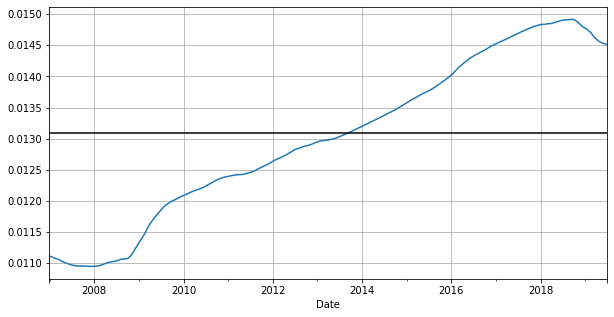

In [37]:
# Plot 10-year moving average for the Dividend Yield.
df[DIVIDEND_YIELD].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[DIVIDEND_YIELD].mean(), color='black');

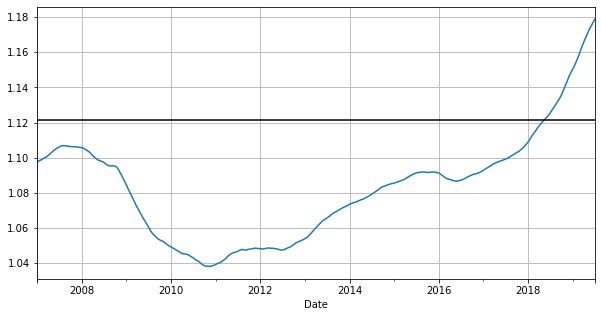

In [38]:
# Plot 10-year moving average for the P/Sales ratio.
df[PSALES].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[PSALES].mean(), color='black');

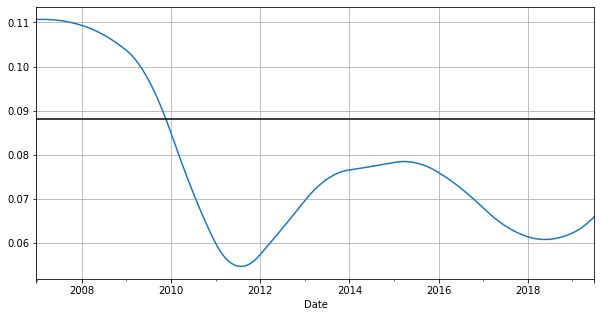

In [39]:
# Plot 10-year moving average for the growth in Sales Per Share.
df[SALES_GROWTH].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[SALES_GROWTH].mean(), color='black');

## S&P 600 (US Small-Cap)

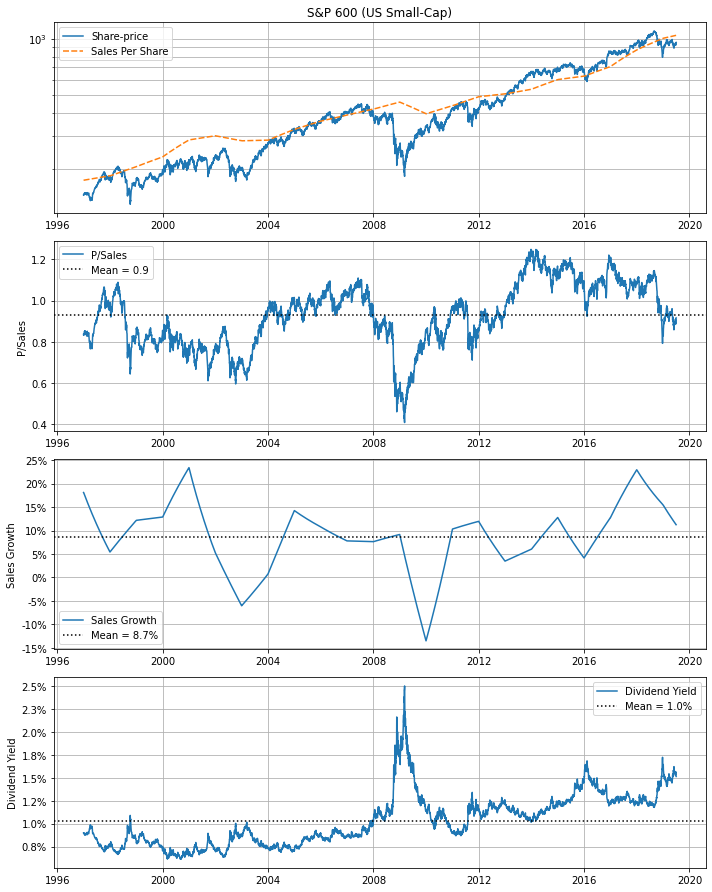

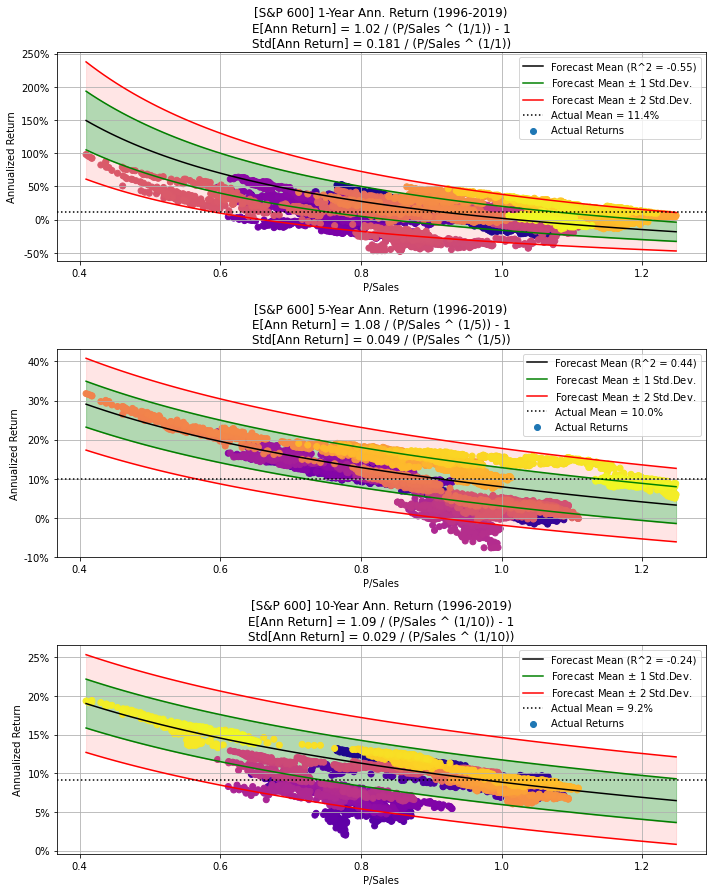

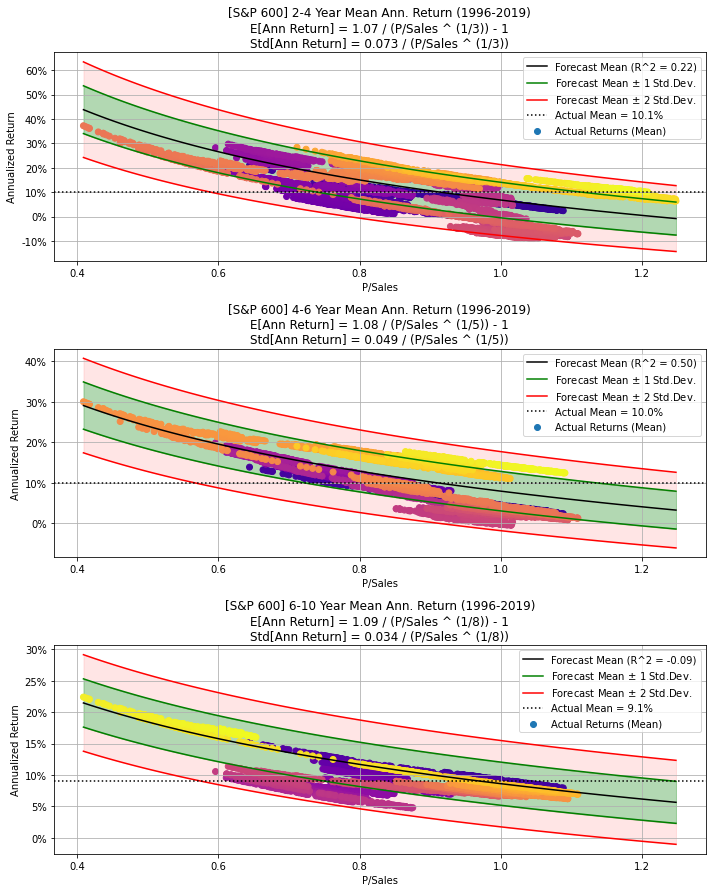

In [40]:
make_all_plots(title=title_SP600, ticker=ticker_SP600, df=df_SP600)

In [41]:
print_stats(df=df_SP600)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  8218.000000   8218.000000  8218.000000   8218.000000     8218.000000
mean    427.043066      9.034135     0.928706      0.086908        0.010278
std     242.649895      5.783045     0.154148      0.068402        0.002822
min     128.699997      2.389033     0.409077     -0.134935        0.006130
25%     222.514995      4.236255     0.816947      0.056530        0.007985
50%     363.530004      7.322080     0.939972      0.090214        0.009607
75%     616.562500     13.477880     1.048137      0.124580        0.012155
max    1098.359985     25.265713     1.248116      0.233809        0.025011

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
1996-12-30   144.639999      2.644984  0.835117      0.180864        0.008986
1996-12-31   145.479996      2.662356  0.839614      0.180774        0.008936
1997-01-01   144.869996      2.651193  0.835970      0.180365        0.008974
1997-01-02   144.259995      2.640030  0.832326      0.179956        0.009012
1997-01-03   145.199997      2.657232  0.837625      0.179548        0.008953

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-06-26   922.640015     21.473622  0.886525      0.113262        0.015656
2019-06-27   940.340027     21.885574  0.903353      0.113045        0.015363
2019-06-28   953.250000     22.186042  0.915573      0.112828        0.015156
2019-06-29   953.776672     22.198300  0.915897      0.112611        0.015149
2019-06-30   954.303345     22.247934  0.916221      0.112394        0.015142

In [42]:
# Get the data used by the forecasting model and remove missing rows.
df = df_SP600[[PSALES, SALES_GROWTH, DIVIDEND_YIELD]].dropna()

In [43]:
# Statistics for the entire data-period.
df.describe()

P/Sales  Sales Growth  Dividend Yield
count  8218.000000   8218.000000     8218.000000
mean      0.928706      0.086908        0.010278
std       0.154148      0.068402        0.002822
min       0.409077     -0.134935        0.006130
25%       0.816947      0.056530        0.007985
50%       0.939972      0.090214        0.009607
75%       1.048137      0.124580        0.012155
max       1.248116      0.233809        0.025011

In [44]:
# Statistics for only the last 10 years.
df_past10year = df[-10*365:]
df_past10year.describe()

P/Sales  Sales Growth  Dividend Yield
count  3650.000000   3650.000000     3650.000000
mean      1.013198      0.087078        0.012171
std       0.131516      0.075834        0.001607
min       0.602618     -0.134935        0.008676
25%       0.912391      0.052491        0.011169
50%       1.039301      0.095567        0.012113
75%       1.118669      0.123798        0.012898
max       1.248116      0.229312        0.017233

In [45]:
# Forecasting model using only past 10 years of financial data.
model = ForecastModel(dividend_yield=df_past10year[DIVIDEND_YIELD],
                      sales_growth=df_past10year[SALES_GROWTH],
                      psales=df_past10year[PSALES], years=8)

In [46]:
# Forecasting model's parameter `a`.
model.a

1.101044876971532

In [47]:
# Forecasting model's parameter `b`.
model.b

0.03356651357393459

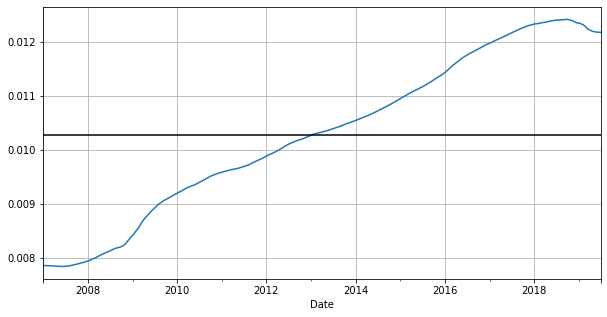

In [48]:
# Plot 10-year moving average for the Dividend Yield.
df[DIVIDEND_YIELD].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[DIVIDEND_YIELD].mean(), color='black');

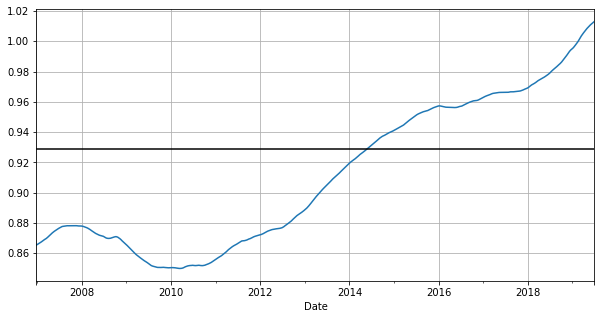

In [49]:
# Plot 10-year moving average for the P/Sales ratio.
df[PSALES].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[PSALES].mean(), color='black');

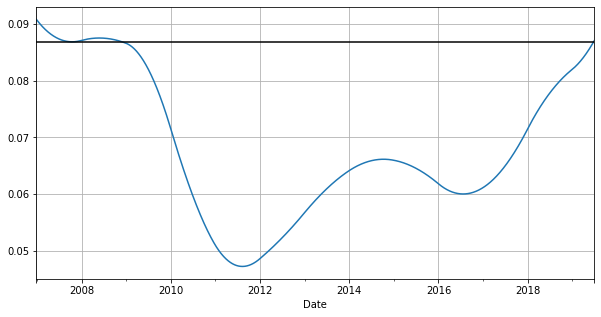

In [50]:
# Plot 10-year moving average for the growth in Sales Per Share.
df[SALES_GROWTH].rolling(10*365).mean().dropna().plot(figsize=(10,5), grid=True);
plt.axhline(df[SALES_GROWTH].mean(), color='black');

## Compare P/Sales for S&P 500, 400, 600

In [51]:
# Create a new DataFrame with the P/Sales for S&P 500, 400, 600.
data = \
{
    ticker_SP500: df_SP500[PSALES],
    ticker_SP400: df_SP400[PSALES],
    ticker_SP600: df_SP600[PSALES]
}
df = pd.DataFrame(data)

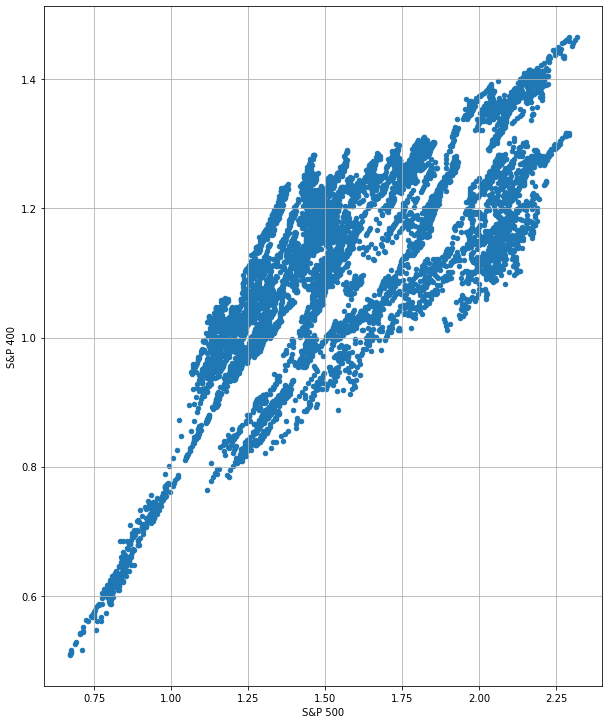

In [52]:
# Plot P/Sales for S&P 500 vs. S&P 400.
df.plot(kind='scatter', x=ticker_SP500, y=ticker_SP400, grid=True);

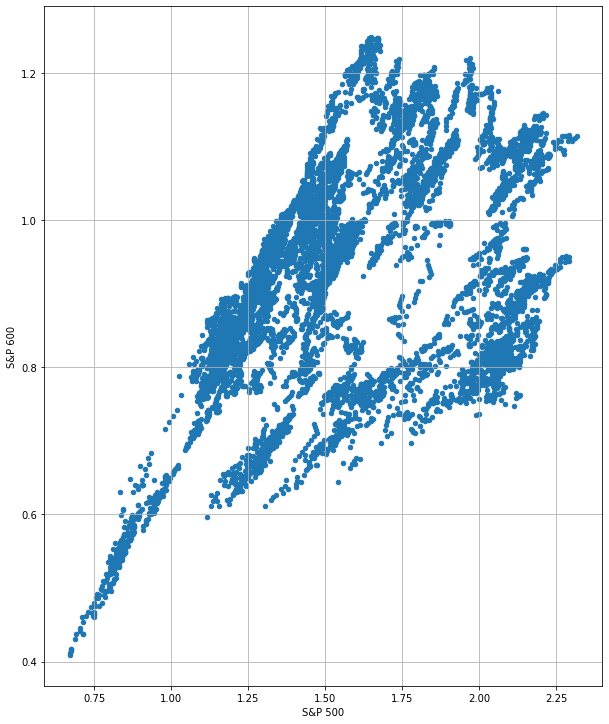

In [53]:
# Plot P/Sales for S&P 500 vs. S&P 600.
df.plot(kind='scatter', x=ticker_SP500, y=ticker_SP600, grid=True);

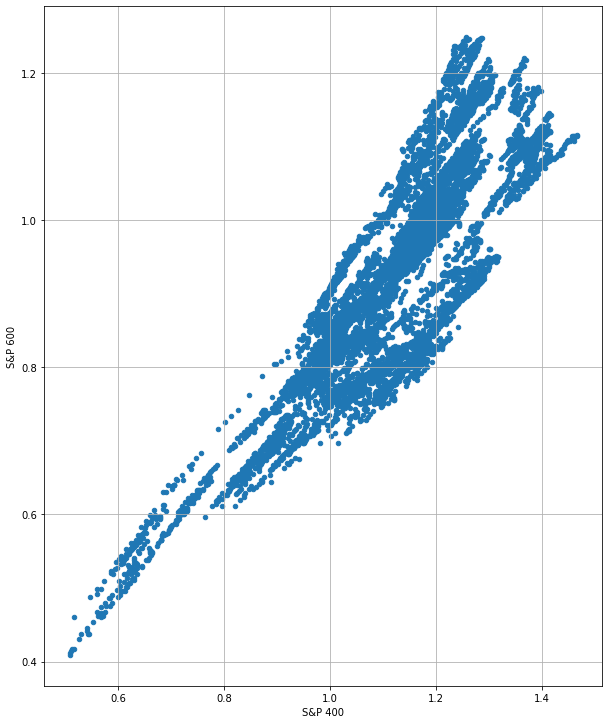

In [54]:
# Plot P/Sales for S&P 400 vs. S&P 600.
df.plot(kind='scatter', x=ticker_SP400, y=ticker_SP600, grid=True);

## QQQ (NASDAQ 100)

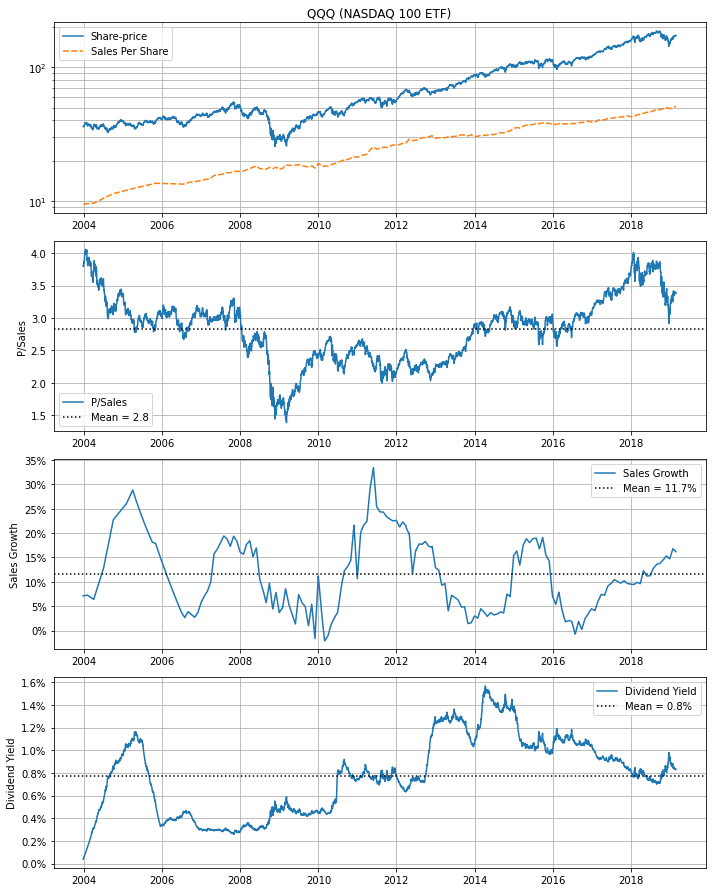

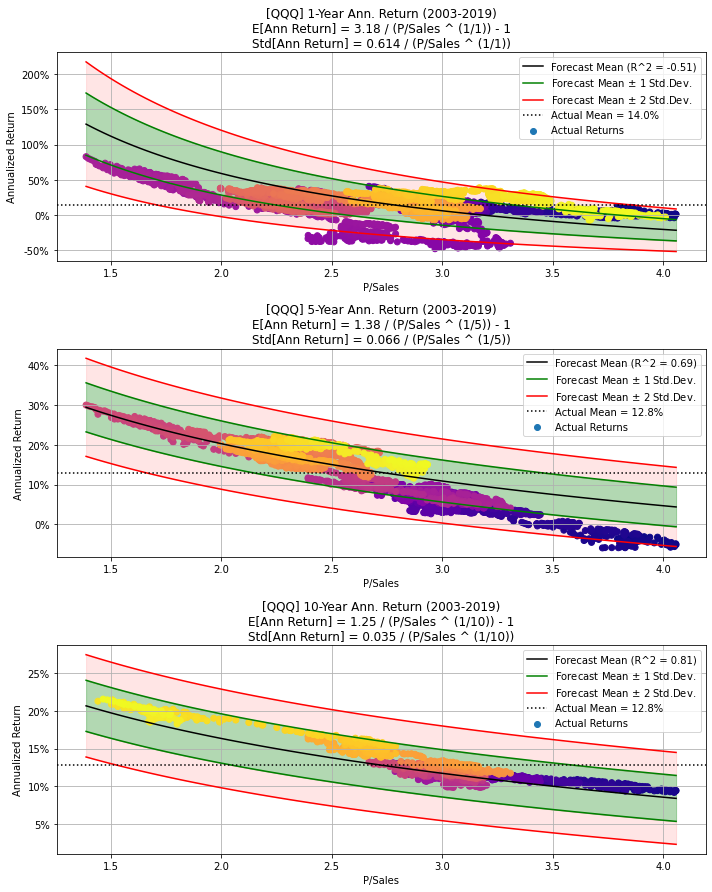

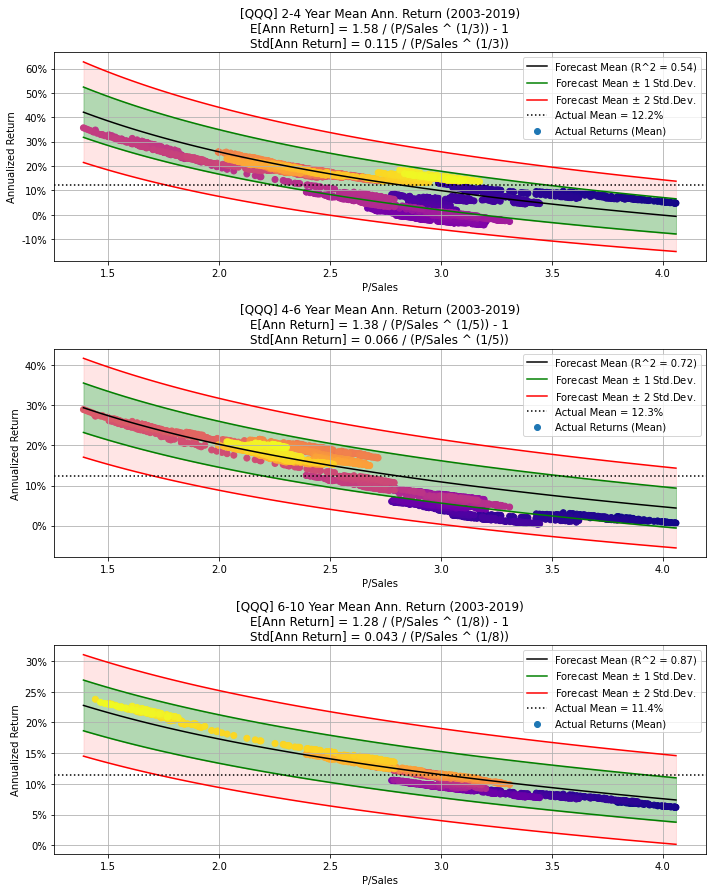

In [55]:
make_all_plots(title=title_QQQ, ticker=ticker_QQQ, df=df_QQQ)

In [56]:
print_stats(df=df_QQQ)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  5546.000000   5546.000000  5546.000000   5546.000000     5546.000000
mean     74.872271     71.028907     2.823328      0.117001        0.007746
std      41.684489     42.551899     0.507504      0.074781        0.003404
min      25.559999     23.006998     1.387867     -0.020979        0.000390
25%      42.137500     37.699922     2.427855      0.052133        0.004519
50%      56.919998     52.209252     2.901781      0.101943        0.007769
75%     105.170000    101.419400     3.099959      0.176557        0.010486
max     186.740005    185.535126     4.059062      0.334211        0.015679

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2003-12-24    35.900002     31.637701  3.801264      0.071500        0.000390
2003-12-25    35.875000     31.615670  3.797603      0.071509        0.000419
2003-12-26    35.849998     31.593639  3.793944      0.071517        0.000447
2003-12-27    36.046665     31.766950  3.813740      0.071526        0.000473
2003-12-28    36.243332     31.940260  3.833525      0.071534        0.000498

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-02-24   173.310002    172.995168  3.397379      0.162592        0.008313
2019-02-25   173.520004    173.204788  3.398046      0.162372        0.008306
2019-02-26   173.699997    173.384445  3.398125      0.162152        0.008301
2019-02-27   173.589996    173.274643  3.392536      0.161933        0.008309
2019-02-28   173.190002    172.875381  3.381296      0.161715        0.008331

## VGK (Europe Developed ETF)

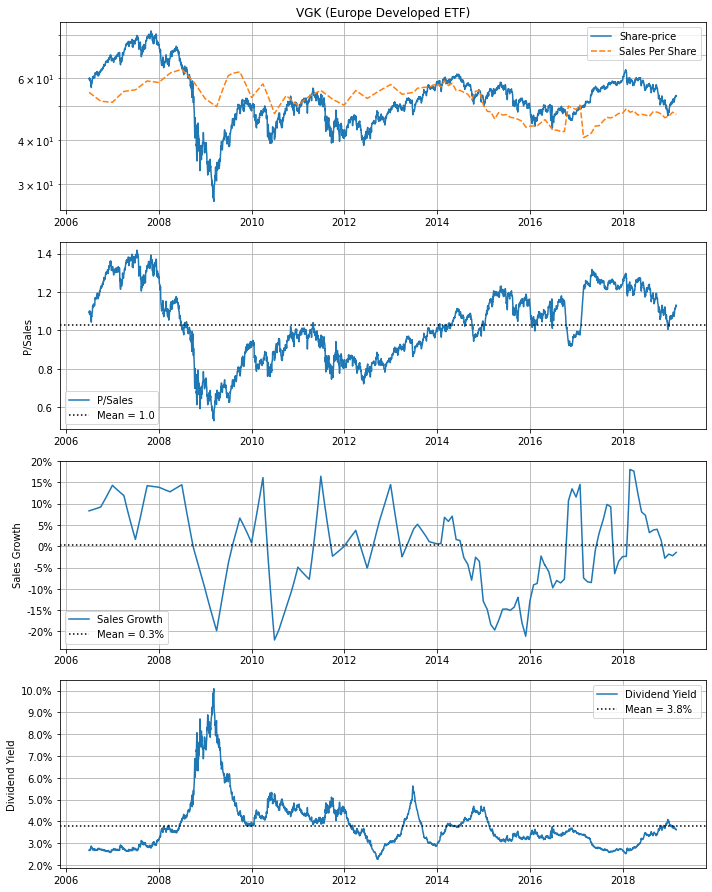

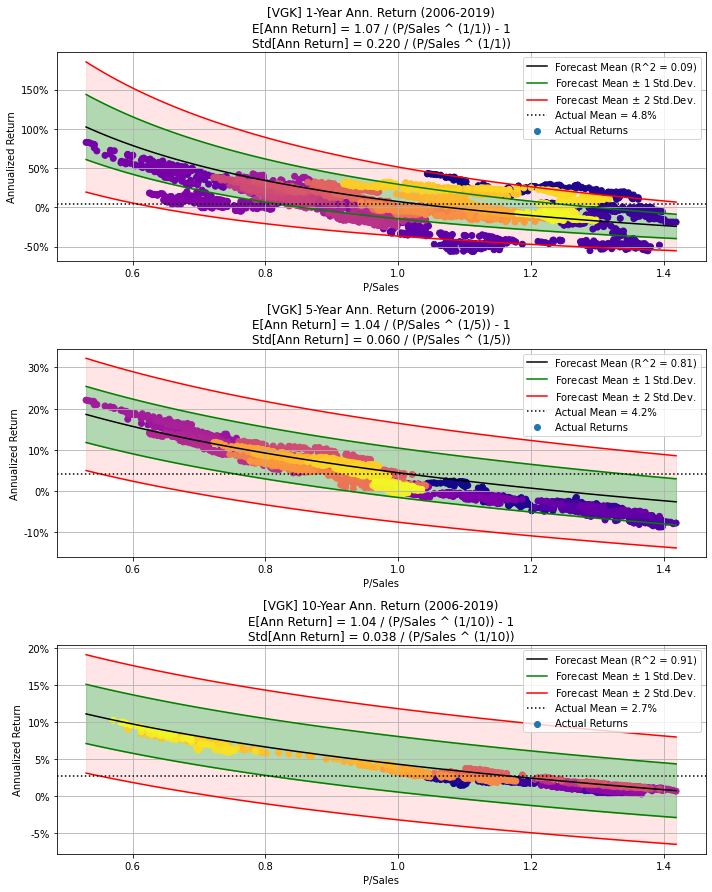

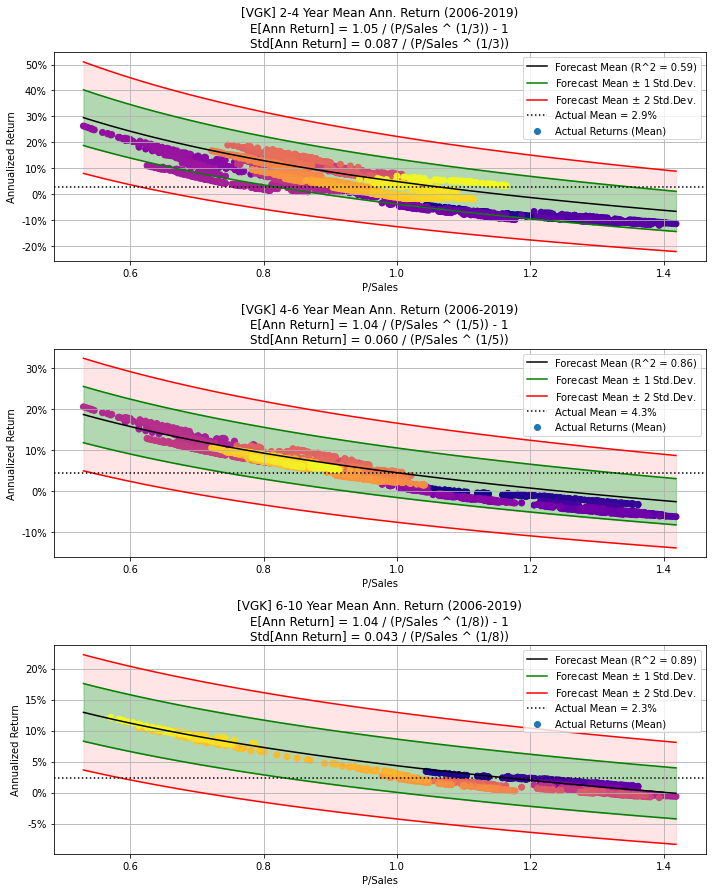

In [57]:
make_all_plots(title=title_VGK, ticker=ticker_VGK, df=df_VGK)

In [58]:
print_stats(df=df_VGK)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  4627.000000   4627.000000  4627.000000   4627.000000     4627.000000
mean     53.585120     42.402468     1.030507      0.003117        0.038119
std       9.708248      8.347601     0.184960      0.095488        0.011657
min      26.760000     18.491383     0.530109     -0.220111        0.022640
25%      47.509998     36.165729     0.889960     -0.062400        0.030531
50%      51.869999     43.367298     1.027209      0.011220        0.035341
75%      58.336667     48.321089     1.181603      0.079390        0.042644
max      81.910004     60.963512     1.418060      0.180344        0.100814

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2006-06-30    59.830002     36.145351  1.092985      0.083102        0.026750
2006-07-01    59.956668     36.221875  1.095971      0.083195        0.026713
2006-07-02    60.083333     36.298400  1.098962      0.083288        0.026677
2006-07-03    60.209999     36.374924  1.101955      0.083381        0.026641
2006-07-04    59.664999     36.045676  1.092652      0.083474        0.026904

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-02-24    53.203335     52.899712  1.121183     -0.015501        0.036465
2019-02-25    53.240002     52.936169  1.122564     -0.015217        0.036446
2019-02-26    53.639999     53.333885  1.131611     -0.014933        0.036180
2019-02-27    53.419998     53.115139  1.127582     -0.014648        0.036335
2019-02-28    53.509998     53.204624  1.130095     -0.014363        0.036279

## EEM (Emerging Markets ETF)

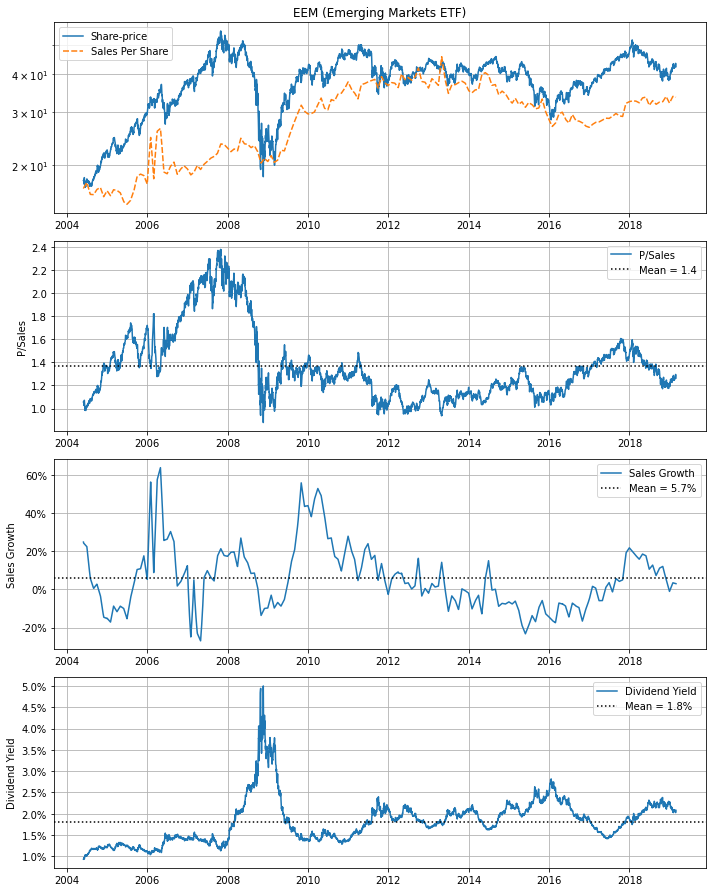

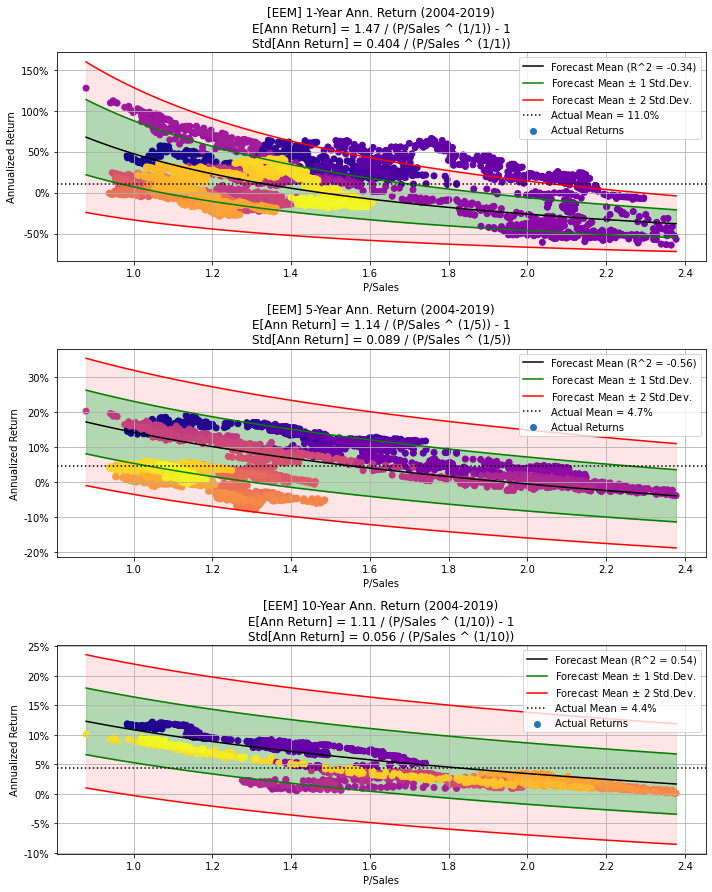

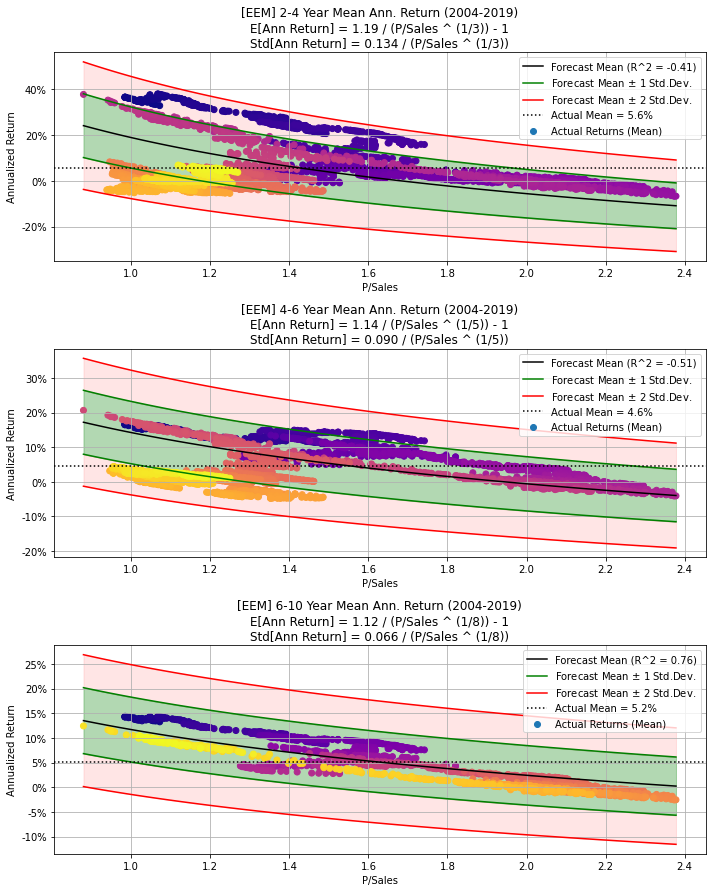

In [59]:
make_all_plots(title=title_EEM, ticker=ticker_EEM, df=df_EEM)

In [60]:
print_stats(df=df_EEM)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  5388.000000   5388.000000  5388.000000   5388.000000     5388.000000
mean     38.059290     33.135555     1.369595      0.057363        0.018153
std       7.829242      7.938319     0.309189      0.163667        0.005279
min      16.827778     12.820470     0.879153     -0.269769        0.009326
25%      33.942500     29.480660     1.144471     -0.073470        0.014141
50%      39.840000     35.037649     1.299433      0.032980        0.017888
75%      43.287501     38.507387     1.477770      0.158680        0.020889
max      55.730000     50.976204     2.377979      0.637546        0.050037

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2004-05-30    17.732779     13.509956  1.056739      0.247632        0.009326
2004-05-31    17.701945     13.486465  1.056833      0.242858        0.009370
2004-06-01    17.671112     13.462975  1.053461      0.242175        0.009415
2004-06-02    17.671112     13.462975  1.051935      0.241495        0.009443
2004-06-03    17.278889     13.164151  1.027099      0.240817        0.009686

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-02-24    43.360000     43.360000  1.290421      0.030403        0.020339
2019-02-25    43.520000     43.520000  1.295486      0.030241        0.020267
2019-02-26    43.369999     43.369999  1.291323      0.030079        0.020339
2019-02-27    43.000000     43.000000  1.280606      0.029917        0.020517
2019-02-28    42.439999     42.439999  1.264224      0.029755        0.020791

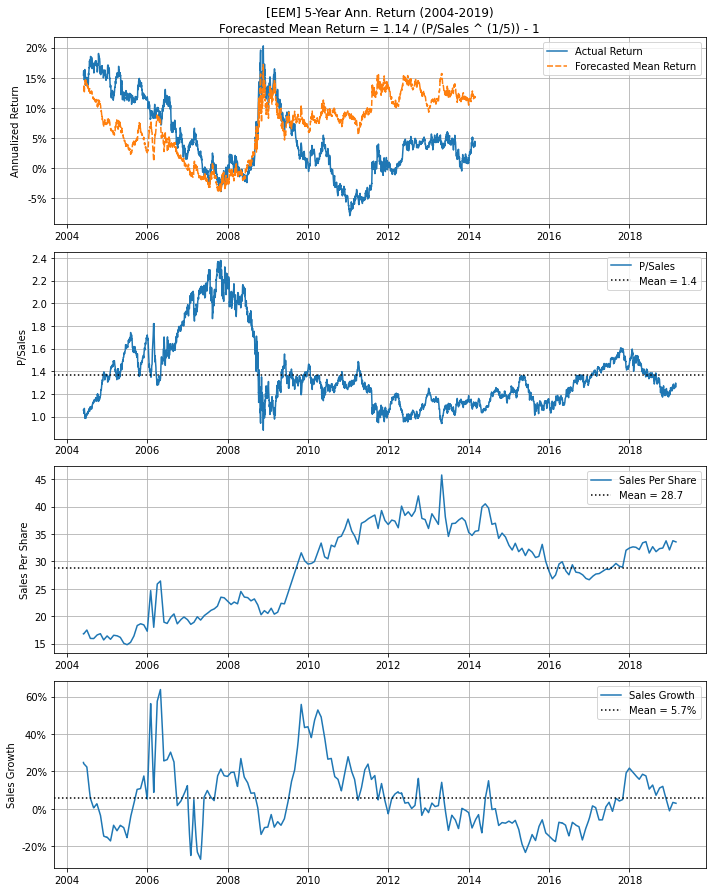

In [61]:
plot_ann_returns_error(ticker=ticker_EEM, df=df_EEM, years=5);

In [62]:
# Statistics for the data from 2010 onwards.
df_past10year = df_EEM['2010-01-01':].dropna()
df_past10year.describe()

Total Return  Share-price  Sales Per Share      P/Sales  Sales Growth  \
count   3346.000000  3346.000000      3346.000000  3346.000000   3346.000000   
mean      37.287118    41.043482        33.696677     1.228249      0.040037   
std        4.180202     4.224081         3.907509     0.146880      0.146300   
min       26.597223    28.250000        26.660000     0.938242     -0.232971   
25%       34.421339    38.570000        30.781129     1.110410     -0.073025   
50%       36.981552    41.278332        33.241000     1.217320      0.016170   
75%       39.579008    43.759165        37.124435     1.332034      0.119573   
max       50.976204    52.080002        45.790000     1.605804      0.528337   

       Dividend TTM   P/Dividend  Dividend Yield  
count   3346.000000  3346.000000     3346.000000  
mean       0.775404    53.793726        0.019081  
std        0.098241     8.909349        0.003021  
min        0.582256    35.476870        0.012838  
25%        0.723349    47.214553        0.016881  
50%        0.792287    51.844062        0.019289  
75%        0.835232    59.238729        0.021180  
max        0.987000    77.896018        0.028187

In [63]:
# Forecasting model using only financial data from 2010 onwards.
model = ForecastModel(dividend_yield=df_past10year[DIVIDEND_YIELD],
                      sales_growth=df_past10year[SALES_GROWTH],
                      psales=df_past10year[PSALES], years=5)

In [64]:
# Forecasting model's parameter `a`.
model.a

1.1031226048609764

In [65]:
# Forecasting model's parameter `b`.
model.b

0.07119295184399939

In [66]:
# Forecasted mean return for 5-year investment periods,
# using the P/Sales ratio from October 2020.
psales_today = 1.17
model.a / (psales_today ** (1/5)) - 1

0.06902192338528845

In [67]:
# Forecasted std.dev.
model.b / (psales_today ** (1/5))

0.06899217364994527

## EWO (Austria ETF)

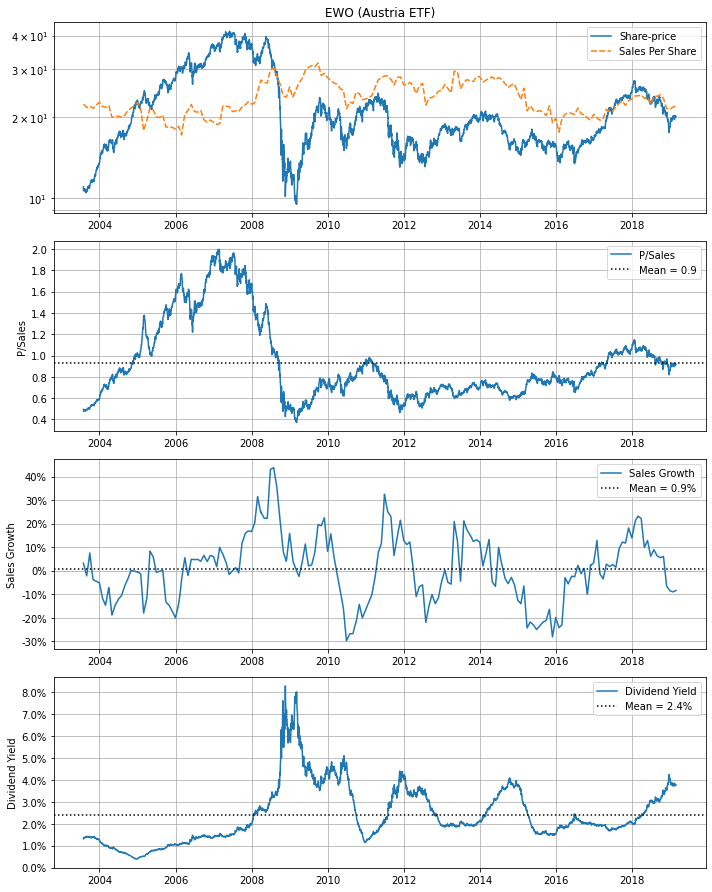

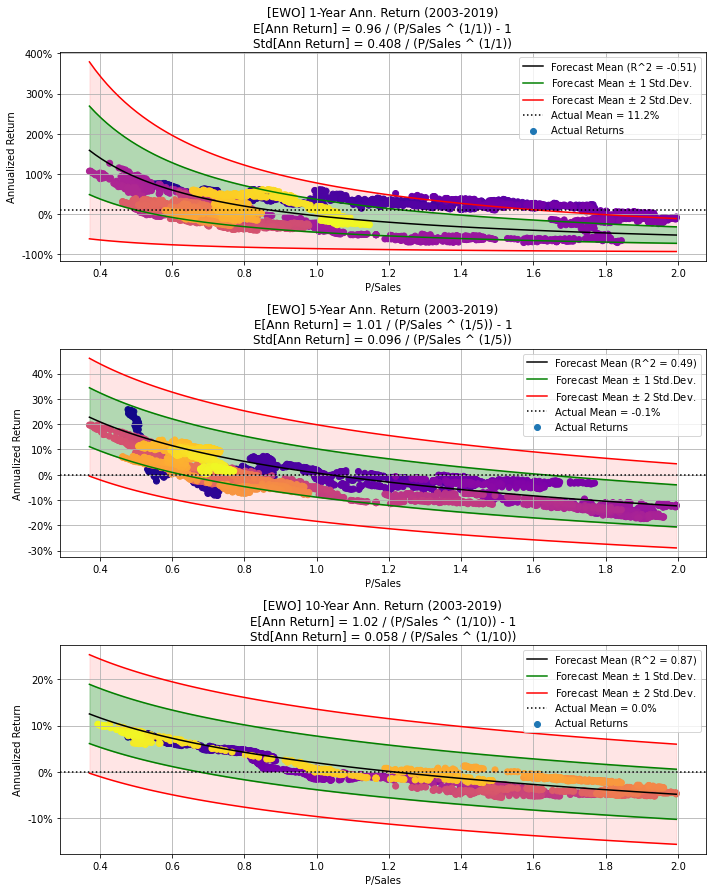

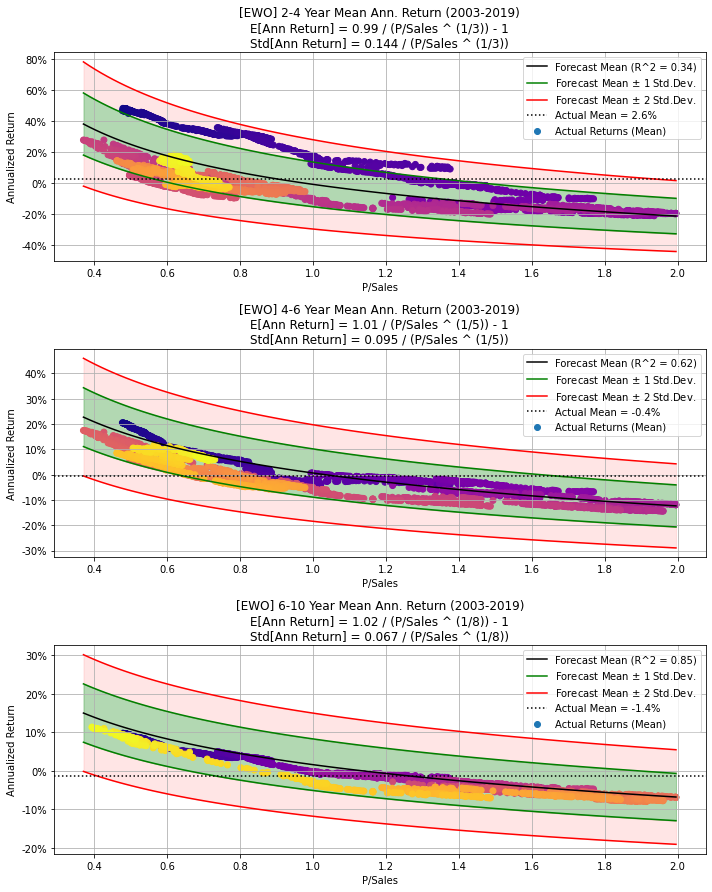

In [68]:
make_all_plots(title=title_EWO, ticker=ticker_EWO, df=df_EWO)

In [69]:
print_stats(df=df_EWO)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  5692.000000   5692.000000  5692.000000   5692.000000     5692.000000
mean     21.268928     17.282815     0.930007      0.008849        0.023931
std       7.172621      5.012735     0.370274      0.137181        0.013273
min       9.490000      7.261663     0.371358     -0.298263        0.003843
25%      16.073333     13.975191     0.678001     -0.085081        0.014523
50%      19.330000     16.132092     0.796817      0.010140        0.019901
75%      23.814167     20.981448     1.047717      0.096632        0.032855
max      41.599998     29.869637     1.995375      0.437689        0.082961

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2003-07-31        11.02      7.698383  0.494281      0.031698        0.013112
2003-08-01        10.65      7.439909  0.478132      0.029921        0.013585
2003-08-02        10.69      7.467852  0.480376      0.028146        0.013551
2003-08-03        10.73      7.495794  0.482625      0.026374        0.013518
2003-08-04        10.77      7.523737  0.484878      0.024605        0.013485

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2019-02-24    19.960001     19.960001  0.911594     -0.084901        0.037890
2019-02-25    19.950001     19.950001  0.910885     -0.084674        0.037919
2019-02-26    20.000000     20.000000  0.912914     -0.084448        0.037835
2019-02-27    20.010000     20.010000  0.913118     -0.084221        0.037826
2019-02-28    20.110001     20.110001  0.917427     -0.083995        0.037649

In [70]:
# Statistics for the data from 2010 onwards.
df_past10year = df_EWO['2010-01-01':].dropna()
df_past10year.describe()

Total Return  Share-price  Sales Per Share      P/Sales  Sales Growth  \
count   3346.000000  3346.000000      3346.000000  3346.000000   3346.000000   
mean      16.639649    18.566980        24.041826     0.779996     -0.012746   
std        3.320761     3.168822         2.789815     0.146061      0.137632   
min       10.807579    13.030000        17.540000     0.463371     -0.298263   
25%       14.287646    16.010000        21.486280     0.669003     -0.112145   
50%       15.661982    17.953334        23.900214     0.753380     -0.010457   
75%       18.208716    20.837500        26.524931     0.895979      0.100506   
max       26.338203    27.260000        29.510000     1.145684      0.324615   

       Dividend TTM   P/Dividend  Dividend Yield  
count   3346.000000  3346.000000     3346.000000  
mean       0.472040    43.326516        0.025765  
std        0.160536    13.827871        0.008834  
min        0.237000    19.570310        0.011525  
25%        0.342692    29.911197        0.019087  
50%        0.441288    45.608169        0.021926  
75%        0.585958    52.392983        0.033432  
max        0.884514    86.766380        0.051098

In [71]:
# Forecasting model using only financial data from 2010 onwards.
model = ForecastModel(dividend_yield=df_past10year[DIVIDEND_YIELD],
                      sales_growth=df_past10year[SALES_GROWTH],
                      psales=df_past10year[PSALES], years=5)

In [72]:
# Forecasting model's parameter `a`.
model.a

0.9609432743633799

In [73]:
# Forecasting model's parameter `b`.
model.b

0.07084622211709629

In [74]:
# Forecasted mean return for 5-year investment periods,
# using the P/Sales ratio from October 2020.
psales_today = 0.62
model.a / (psales_today ** (1/5)) - 1

0.057351567851465335

In [75]:
# Forecasted std.dev.
model.b / (psales_today ** (1/5))

0.07795399169788873

In [76]:
# Annualized return from revaluation in P/Sales ratio.
(df_past10year[PSALES].mean() / psales_today) ** (1/5) - 1

0.046984159557284855

## PG (Procter & Gamble)

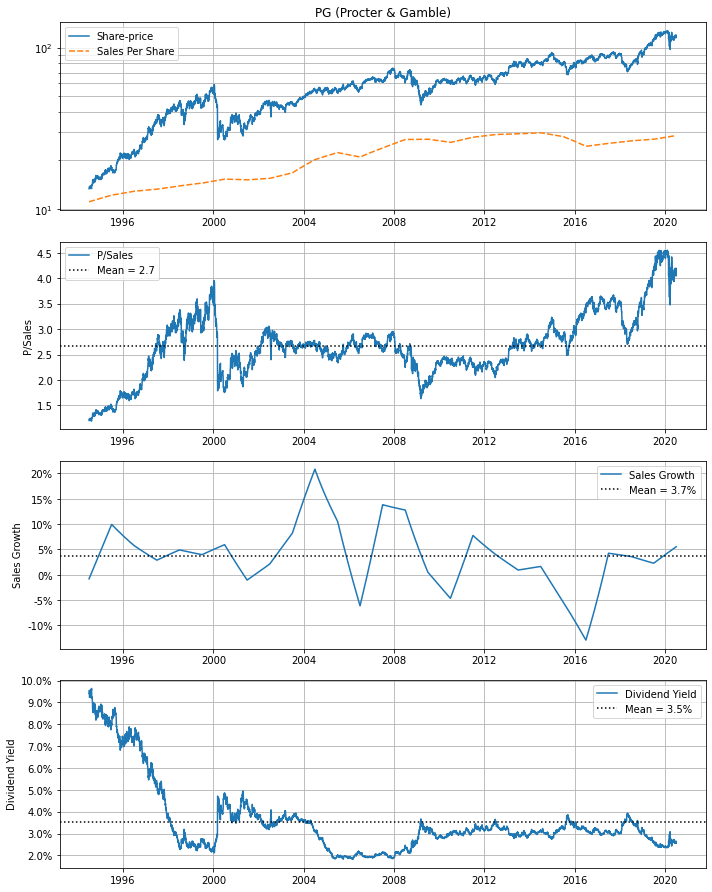

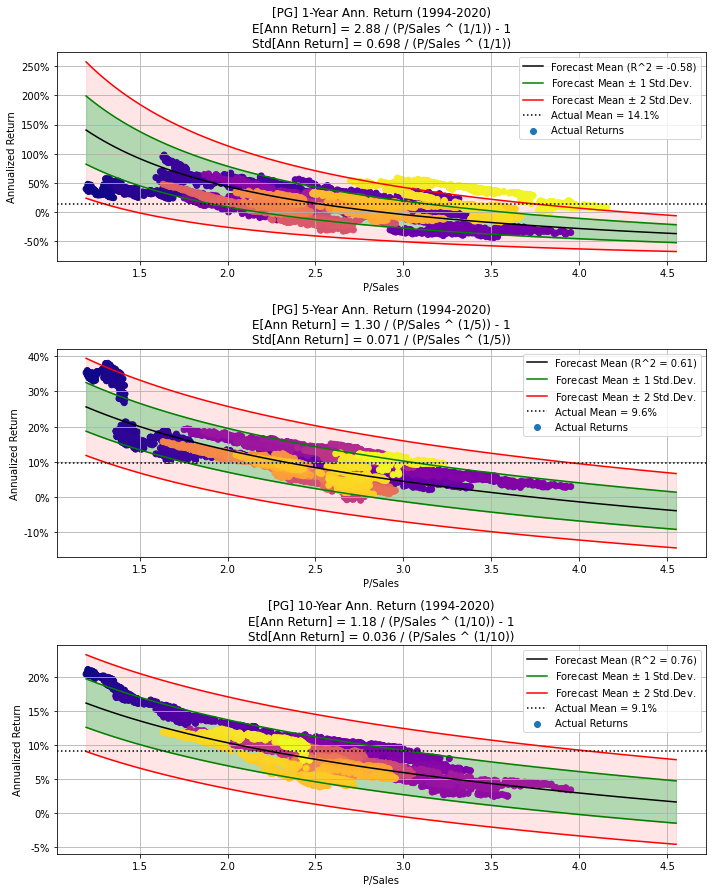

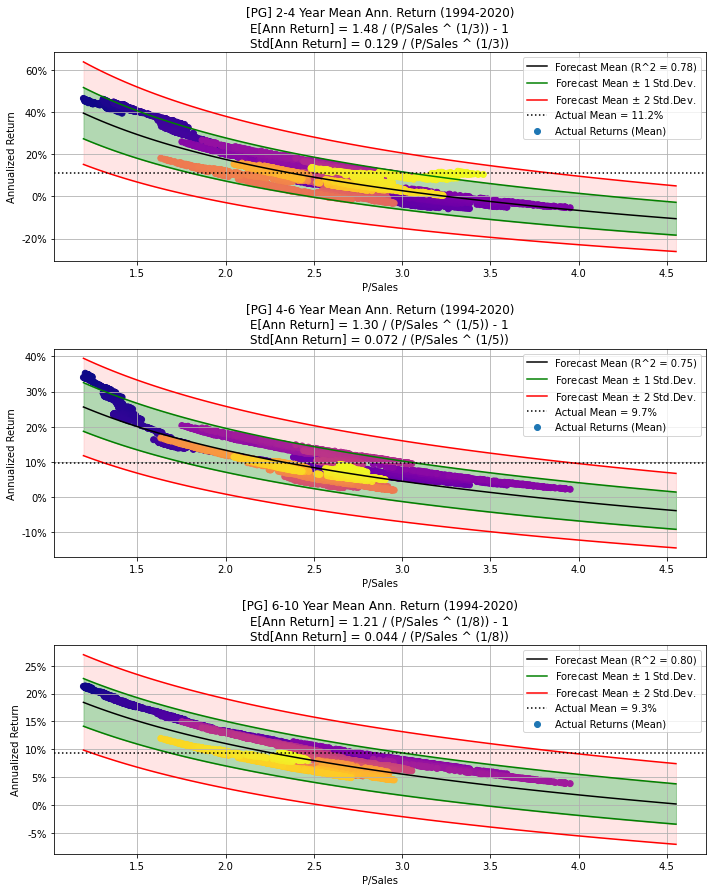

In [77]:
make_all_plots(title=title_PG, ticker=ticker_PG, df=df_PG)

In [78]:
print_stats(df=df_PG)

Share-price  Total Return      P/Sales  Sales Growth  Dividend Yield
count  9498.000000   9498.000000  9498.000000   9498.000000     9498.000000
mean     59.399868     44.439943     2.676643      0.037449        0.035380
std      24.150967     26.981957     0.630485      0.057922        0.016092
min      13.343750      5.120126     1.195205     -0.128874        0.018226
25%      43.067499     23.070134     2.334163      0.010677        0.026572
50%      59.893335     40.959873     2.664155      0.038035        0.031111
75%      77.550000     64.618013     2.967450      0.059176        0.036374
max     127.139999    125.505730     4.551160      0.208162        0.096424

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
1994-06-30     13.34375      5.120126  1.205397     -0.008065        0.095332
1994-07-01     13.53125      5.192069  1.222002     -0.007773        0.094044
1994-07-02     13.53125      5.192069  1.221670     -0.007481        0.094076
1994-07-03     13.53125      5.192069  1.221338     -0.007189        0.094109
1994-07-04     13.53125      5.192069  1.221006     -0.006897        0.094141

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2020-06-26   115.230003    114.507416  4.041229      0.055080        0.026539
2020-06-27   116.040003    115.312337  4.069051      0.055167        0.026358
2020-06-28   116.850004    116.117259  4.096866      0.055255        0.026179
2020-06-29   117.660004    116.922180  4.124673      0.055342        0.026002
2020-06-30   119.570000    118.820198  4.191027      0.055334        0.025591

## WMT (Walmart)

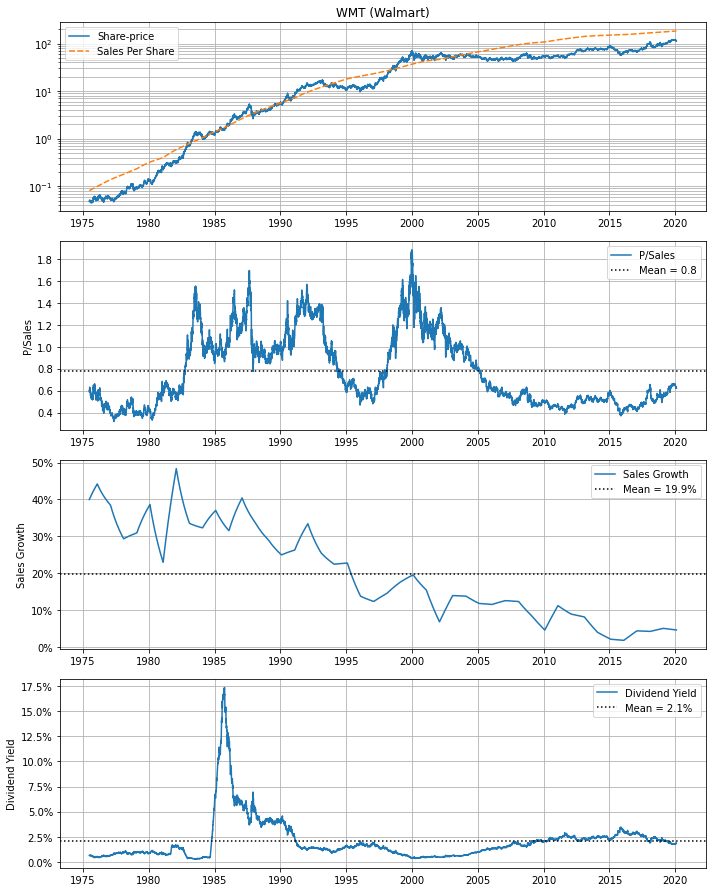

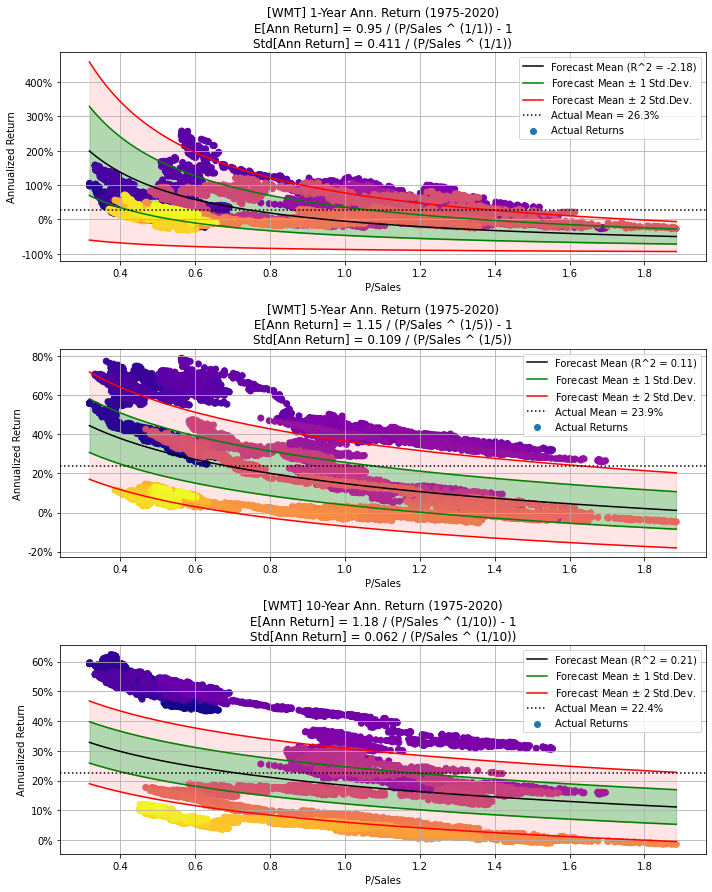

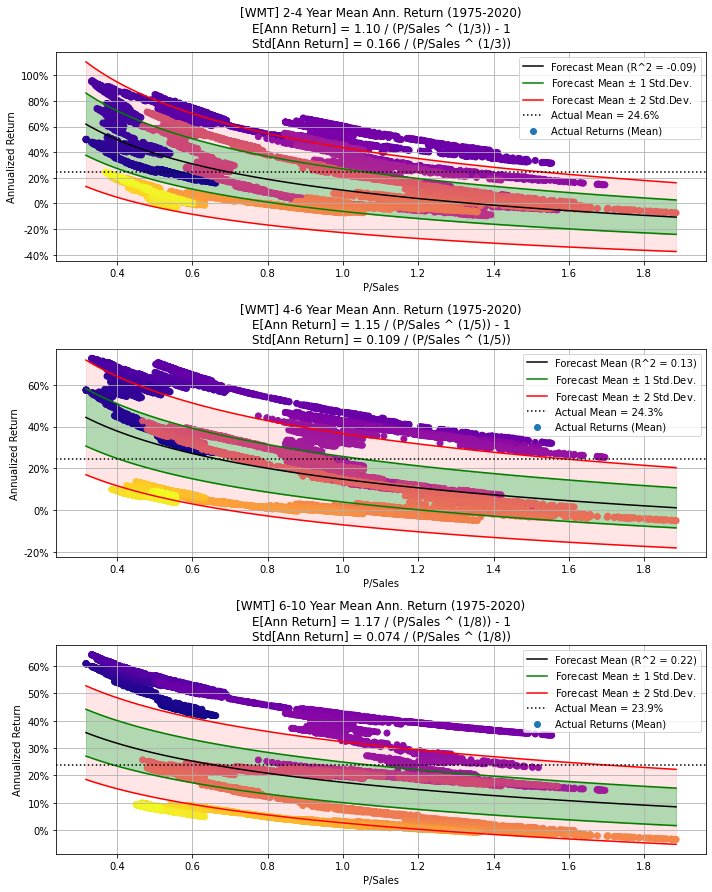

In [79]:
make_all_plots(title=title_WMT, ticker=ticker_WMT, df=df_WMT)

In [80]:
print_stats(df=df_WMT)

Share-price  Total Return       P/Sales  Sales Growth  Dividend Yield
count  16294.000000  16294.000000  16294.000000  16294.000000    16294.000000
mean      33.027446     26.133150      0.775868      0.199499        0.020621
std       31.074684     27.607954      0.327242      0.122883        0.021566
min        0.044922      0.016263      0.317140      0.018642        0.002670
25%        2.851563      1.432372      0.507236      0.097006        0.008542
50%       18.640625     12.493923      0.630453      0.165951        0.014909
75%       55.099998     40.613861      1.015220      0.316214        0.024120
max      121.279999    119.724709      1.884915      0.483538        0.173750

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
1975-06-23     0.048584      0.017589  0.601968      0.399816        0.006587
1975-06-24     0.048584      0.017589  0.601348      0.400042        0.006576
1975-06-25     0.048340      0.017500  0.597711      0.400268        0.006598
1975-06-26     0.047852      0.017323  0.591068      0.400493        0.006655
1975-06-27     0.047363      0.017147  0.584427      0.400719        0.006712

Share-price  Total Return   P/Sales  Sales Growth  Dividend Yield
Date                                                                         
2020-01-27   115.860001    114.374222  0.630497      0.046908        0.018342
2020-01-28   116.599998    115.104721  0.634446      0.046897        0.018226
2020-01-29   115.889999    114.403831  0.630505      0.046885        0.018338
2020-01-30   116.580002    115.084984  0.634182      0.046874        0.018231
2020-01-31   114.489998    113.021790  0.622736      0.046863        0.018564

## Inflation

As explained in the paper, we need to make modifications to the forecasting model in order to adjust for inflation. This is not done here. Instead we just show the Consumer Price Index (CPI) for USA, so we can see that inflation was fairly stable in USA during the period we consider here e.g. for the US stock-indices.

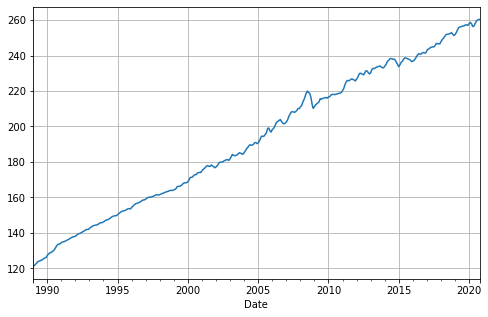

In [81]:
# Use CPI data for roughly the same period as the S&P 500 data.
df_CPI2 = df_CPI['1989':]

# Plot the CPI for this period.
# Note that it shows fairly steady growth.
df_CPI2.plot(grid=True, figsize=(8, 5));

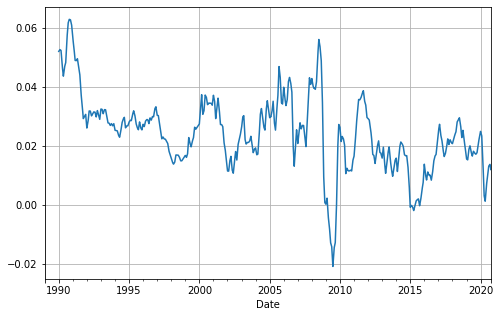

In [82]:
# Plot the yearly percentage change in CPI for this period.
# Note that there is perhaps a slight downwards trend.
df_CPI2.pct_change(365).plot(grid=True, figsize=(8, 5));